# Objective:

  * Use Pyspark to practice various data analytics techniques such as data visualization, and classification tasks such as brand classification.
# Questions:
  * 	Can we segment cars based on their customer feedback (brand classification)
# Dataset:
  * [On Kaggle](https://www.kaggle.com/datasets/ahmettalhabektas/new-york-cars-big-data-2023)
  * About the data:    
This dataset comprises the car rates obtained from the cars.com website, encompasses seven distinct categories of car ratings.
    
    General Rate
    Comfort
    Interior Design
    Performance
    Value For The Money
    Exterior Styling
    Reliabilityability)
 

# Table of contents:
</ul>

<li><a href="#eda">Exploratory Data Analysis</a></li>

1. <a href="#dataS">Understanding Data Structure</a></li>
2. <a href="#dataS2">Visualization</a></li>
   1. <a href="#dataS2a">Categorical Variables</a></li>
   2. <a href="#dataS2b">Discrete and Continuous Variables</a></li>
3. <a href="#dataS3">Correlation</a></li>
4. <a href="#dataS4">Logarithmic Transformation</a></li>

<li><a href="#pre-process">Data Pre-Processing.</a></li>

* <a href="#over">Oversampling</a></li>

<li><a href="#modeling">Data Modeling</a></li>

   1.  <a href="#multiC">Multiclass Classification</a></li>
     * <a href="#multiCa">Random Forest</a></li>
     * <a href="#multiCb">Random Forest with oversampled data</a></li>
     * <a href="#multiCc">Logistic Regression</a></li>

   2.  <a href="#binary">Binary Class Classification Without Log Transformation</a></li>
       * <a href="#gbt"> Gradient Boosted Tree Classifier</a></li>
       * <a href="#lrT"> Logistic Regression.</a></li>
   3. <a href="#binary2">Binary Class Classification With Log Transformation</a></li>
      * <a href="#binarya">Logistic Regression </a></li>
      * <a href="#binaryb"> Gradient Boosted Tree Classifier</a></li>
   

     
<!-- <li><a href="#conclusions">Conclusions</a></li> -->  
</ul>

<a id="eda"></a>
# Exploratory Data Analysis

In [4]:
from pyspark.sql import SparkSession
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', None)
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import re

In [5]:
SparkSession.getActiveSession()

In [6]:
spark = SparkSession.builder \
    .master("local")\
    .appName("Car Ratings Classification Project2") \
    .getOrCreate()

In [4]:
#spark data frame
car_rates_sdf=spark.read.csv(
    path="Car_Rates.csv",
    header=True,
    inferSchema=True
)

<a id="dataS" ></a>
## Understanding Data Structure

In [5]:
car_rates_sdf.show(5)

+--------------------+--------------+------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-----+--------+
|            Car_name|Num_of_reviews|General_rate|Comfort|Interior design|Performance|Value for the money|Exterior styling|Reliability|Year|Brand|   Model|
+--------------------+--------------+------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-----+--------+
|2023     Acura   ...|           5.0|         4.6|    4.4|            4.4|        4.6|                4.2|             5.0|        4.8|2023|Acura|Integra.|
|2023     Acura   ...|          NULL|        NULL|   NULL|           NULL|       NULL|               NULL|            NULL|       NULL|2023|Acura|    MDX.|
|2023     Acura   ...|          NULL|        NULL|   NULL|           NULL|       NULL|               NULL|            NULL|       NULL|2023|Acura|    TLX.|
|2023     Acura   ...|          NULL|        NULL|   NULL|      

In [6]:
car_rates_sdf.printSchema()

root
 |-- Car_name: string (nullable = true)
 |-- Num_of_reviews: double (nullable = true)
 |-- General_rate: double (nullable = true)
 |-- Comfort: double (nullable = true)
 |-- Interior design: double (nullable = true)
 |-- Performance: double (nullable = true)
 |-- Value for the money: double (nullable = true)
 |-- Exterior styling: double (nullable = true)
 |-- Reliability: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Model: string (nullable = true)



In [7]:
car_rates_sdf.printSchema()

root
 |-- Car_name: string (nullable = true)
 |-- Num_of_reviews: double (nullable = true)
 |-- General_rate: double (nullable = true)
 |-- Comfort: double (nullable = true)
 |-- Interior design: double (nullable = true)
 |-- Performance: double (nullable = true)
 |-- Value for the money: double (nullable = true)
 |-- Exterior styling: double (nullable = true)
 |-- Reliability: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Model: string (nullable = true)



In [8]:
print(f"Columns are:\t{car_rates_sdf.columns}, \n Number of columns: {len(car_rates_sdf.columns)}\n Number of rows: {car_rates_sdf.count()}")

Columns are:	['Car_name', 'Num_of_reviews', 'General_rate', 'Comfort', 'Interior design', 'Performance', 'Value for the money', 'Exterior styling', 'Reliability', 'Year', 'Brand', 'Model'], 
 Number of columns: 12
 Number of rows: 4243


In [5]:
for name in car_rates_sdf.schema.names:
    car_rates_sdf=car_rates_sdf.withColumnRenamed(name, re.sub("\W+","_",name.lower()))


In [6]:
car_rates_sdf.columns

['car_name',
 'num_of_reviews',
 'general_rate',
 'comfort',
 'interior_design',
 'performance',
 'value_for_the_money',
 'exterior_styling',
 'reliability',
 'year',
 'brand',
 'model']

### Null Values

In [11]:
Dict_Null = {col:car_rates_sdf.filter(car_rates_sdf[col].isNull()).count()/car_rates_sdf.count() for col in car_rates_sdf.columns}
Dict_Null

{'car_name': 0.0,
 'num_of_reviews': 0.1329248173462173,
 'general_rate': 0.1329248173462173,
 'comfort': 0.1329248173462173,
 'interior_design': 0.1329248173462173,
 'performance': 0.1329248173462173,
 'value_for_the_money': 0.1329248173462173,
 'exterior_styling': 0.1329248173462173,
 'reliability': 0.13646005185010607,
 'year': 0.0,
 'brand': 0.0,
 'model': 0.0}

In [12]:
car_rates_sdf.na.drop().count() #Show number of rows after dropping NA

3664

In [7]:
car_rates_sdf=car_rates_sdf.na.drop()

In [8]:
car_rates_sdf.count()

3664

<a id="dataS2" ></a>
# Visualization

<a id="dataS2a" ></a>
### Categorical Variables

In [9]:
print(f"Number of values in Model feature: {car_rates_sdf.select('model').distinct().count()}\nCount of must frequent models: {car_rates_sdf.groupBy('model').count().orderBy('count',ascending=False).show()}")

+---------------+-----+
|          model|count|
+---------------+-----+
|       Sorento.|   12|
|        Tiguan.|   12|
|Grand Cherokee.|   12|
|        Sienna.|   12|
|      Sportage.|   12|
|      Traverse.|   12|
|       4Runner.|   12|
|       Outback.|   12|
|       Odyssey.|   12|
|        Camaro.|   12|
|        Malibu.|   12|
|      Frontier.|   12|
|          XC60.|   12|
|        Acadia.|   12|
|            Q5.|   12|
|        Altima.|   12|
|           Rio.|   12|
|    Highlander.|   12|
|      Wrangler.|   12|
|      Forester.|   12|
+---------------+-----+
only showing top 20 rows

Number of values in Model feature: 702
Count of must frequent models: None


In [10]:
print(f"Number of values in Model feature: {car_rates_sdf.select('brand').distinct().count()}\nCount of must frequent models:\n{car_rates_sdf.groupBy('brand').count().orderBy('count',ascending=False).show()}")

+-------------+-----+
|        brand|count|
+-------------+-----+
|          BMW|  342|
|       Toyota|  247|
|         Ford|  242|
|Mercedes-Benz|  241|
|    Chevrolet|  224|
|         Audi|  211|
|       Nissan|  205|
|        Lexus|  181|
|      Hyundai|  155|
|          Kia|  140|
|        Honda|  129|
|   Volkswagen|  122|
|          GMC|  102|
|       Subaru|   95|
|        Volvo|   90|
|     Cadillac|   88|
|         Jeep|   87|
|     INFINITI|   83|
|        Mazda|   79|
|      Porsche|   74|
+-------------+-----+
only showing top 20 rows

Number of values in Model feature: 30
Count of must frequent models:
None


In [12]:
brands_value_count=car_rates_sdf.groupBy("brand").count().orderBy('count',ascending=False)
models_value_count=car_rates_sdf.groupBy("model").count().orderBy('count',ascending=False)

In [13]:
brands_value_count=brands_value_count.toPandas()
models_value_count=models_value_count.toPandas()

In [14]:
def bar_plot(df,x="",y="",x_name="",y_name="",title=""):
        
    plt.figure(figsize=(20,8))
    sns.barplot(x=df[x],y=df[y])
    plt.xlabel(x_name.upper())
    plt.ylabel(y_name.upper())
    plt.title(title.upper())
    plt.xticks(rotation=50);

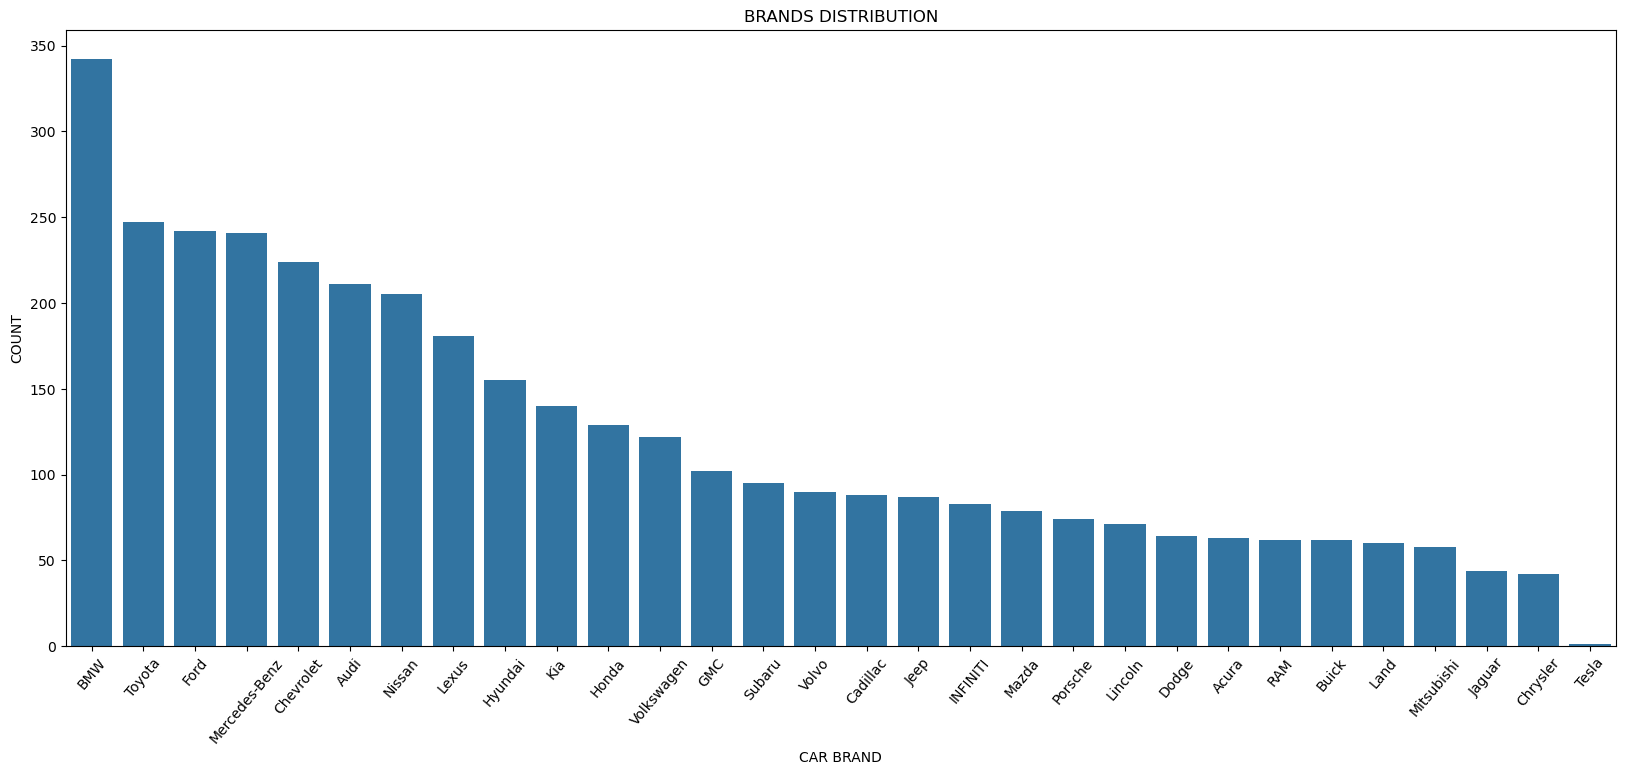

In [15]:
bar_plot(brands_value_count,"brand","count","car brand","count","brands distribution")

#### We have unblanced data. And we should drop tesla records.

In [24]:
car_rates_sdf=car_rates_sdf.filter(car_rates_sdf['brand'] != "Tesla")

In [25]:
car_rates_sdf.select('brand').distinct().count()

29

In [23]:
pd.set_option("display.max_rows", None)
models_value_count.groupby("model").sum()

,count
model,
128.,2
135.,2
1500 Classic.,4
1500.,11
200.,6
228 Gran Coupe.,2
228.,3
230.,5
2500.,10


In [26]:
models_value_count.shape[0]

702

### The "model" variable has high cardinality features{702 values}, which might reduce the algorithm's performance. Also, it has a high correlation with the "Brand" variable "our Y label", because they share common Info, thus we should not include "Model" in our input features.

In [33]:
car_rates_sdf.groupBy("model","brand").count().orderBy('count',ascending=False).show()

+---------------+-------------+-----+
|          model|        brand|count|
+---------------+-------------+-----+
|       Sorento.|          Kia|   12|
|        GX 460.|        Lexus|   12|
|      Santa Fe.|      Hyundai|   12|
|    Highlander.|       Toyota|   12|
|       4Runner.|       Toyota|   12|
|       C-Class.|Mercedes-Benz|   12|
|        Altima.|       Nissan|   12|
|Grand Cherokee.|         Jeep|   12|
|        Acadia.|          GMC|   12|
|          Soul.|          Kia|   12|
|       Mustang.|         Ford|   12|
|         Forte.|          Kia|   12|
|      Wrangler.|         Jeep|   12|
|        Tacoma.|       Toyota|   12|
|          XC60.|        Volvo|   12|
|            Q5.|         Audi|   12|
|        Tiguan.|   Volkswagen|   12|
|        Sonata.|      Hyundai|   12|
|        Sienna.|       Toyota|   12|
|        Camaro.|    Chevrolet|   12|
+---------------+-------------+-----+
only showing top 20 rows



### As we can see each brand have a multiple models.

<a id="dataS3" ></a>
# Correlation

In [27]:
car_ratings_pdf=car_rates_sdf.toPandas()
corr_df=car_ratings_pdf.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corr_df

,car_name,num_of_reviews,general_rate,comfort,interior_design,performance,value_for_the_money,exterior_styling,reliability,year,brand,model
car_name,1.000000,0.120244,0.053618,0.051566,0.064431,0.027293,0.030919,0.093345,0.033963,0.001092,0.996608,0.997458
num_of_reviews,0.120244,1.000000,-0.107960,-0.025626,-0.082806,-0.111745,-0.066587,0.141266,-0.016848,0.212773,0.103431,0.102409
general_rate,0.053618,-0.107960,1.000000,0.387394,0.338680,0.565852,0.441635,0.419182,0.541949,-0.024052,0.051710,0.057406
comfort,0.051566,-0.025626,0.387394,1.000000,0.353613,0.322914,0.302620,0.321637,0.303322,0.053929,0.047770,0.053285
interior_design,0.064431,-0.082806,0.338680,0.353613,1.000000,0.301573,0.291953,0.269073,0.247013,-0.028683,0.063215,0.069887
performance,0.027293,-0.111745,0.565852,0.322914,0.301573,1.000000,0.394071,0.298651,0.415262,-0.001702,0.024189,0.029814
value_for_the_money,0.030919,-0.066587,0.441635,0.302620,0.291953,0.394071,1.000000,0.292614,0.435443,-0.044287,0.033304,0.032319
exterior_styling,0.093345,0.141266,0.419182,0.321637,0.269073,0.298651,0.292614,1.000000,0.369418,0.200169,0.078346,0.088246
reliability,0.033963,-0.016848,0.541949,0.303322,0.247013,0.415262,0.435443,0.369418,1.000000,0.064907,0.028419,0.035277
year,0.001092,0.212773,-0.024052,0.053929,-0.028683,-0.001702,-0.044287,0.200169,0.064907,1.000000,-0.046287,-0.025179


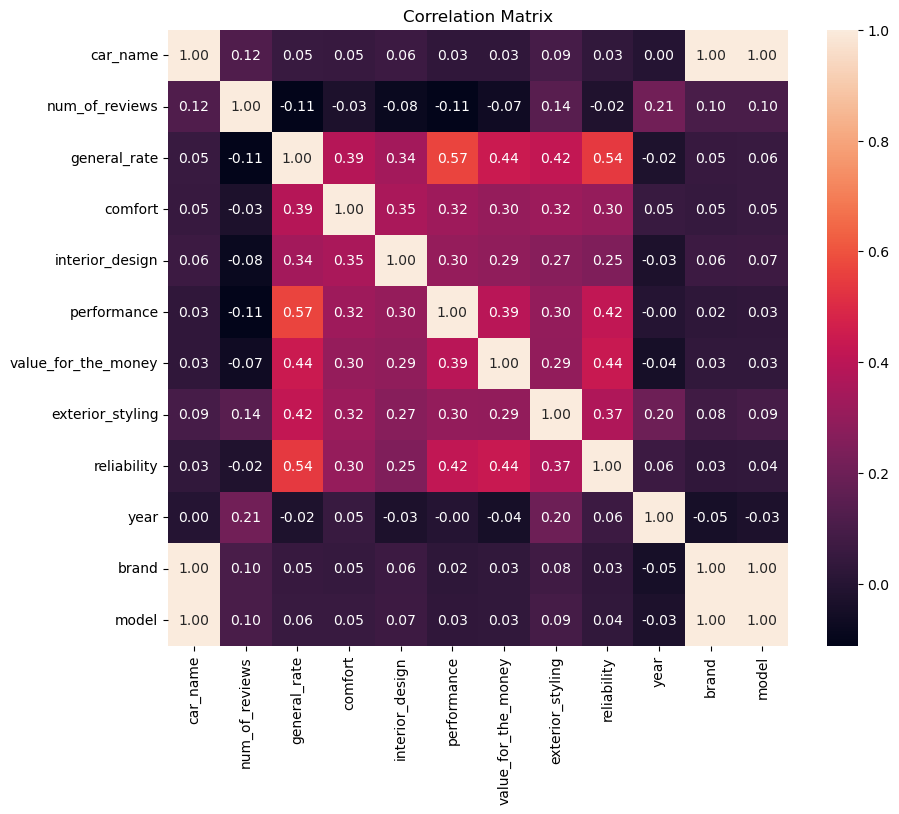

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Insights
* We should drop the general rate as it is correlated with two features [performance, reliability], this might reduce classification models' performance because of multicollinearity.
* The model variable is highly correlated with the brand, which is logical, but we should handle it carefully because of its high cardinality.

#### Drop unuseful cols

In [29]:
car_rates_sdf=car_rates_sdf.drop("car_name","general_rate")

In [30]:
print(f"Columns are:\t{car_rates_sdf.columns}, \n Number of columns: {len(car_rates_sdf.columns)}\n Number of rows: {car_rates_sdf.count()}")

Columns are:	['num_of_reviews', 'comfort', 'interior_design', 'performance', 'value_for_the_money', 'exterior_styling', 'reliability', 'year', 'brand', 'model'], 
 Number of columns: 10
 Number of rows: 3663


In [31]:
car_rates_sdf.toPandas().to_csv("car_rates_modified.csv",index=False)

<a id="dataS2b" ></a>
### Discrete and Continuous Variables

In [34]:
year_value_count=car_rates_sdf.groupBy("year").count().orderBy('count',ascending=False)

In [35]:
year_value_count=car_rates_sdf.groupBy("year").count().orderBy('count',ascending=False)

In [36]:
year_value_count=year_value_count.toPandas()

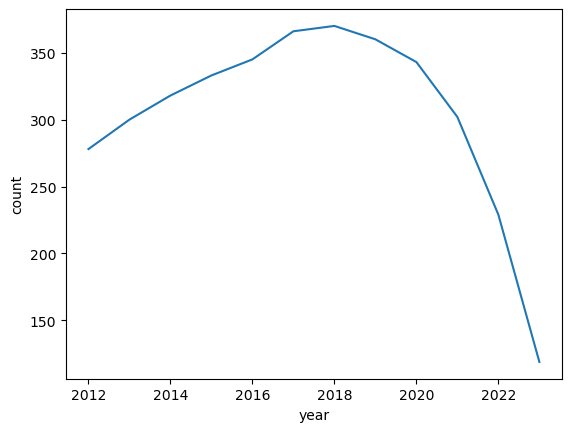

In [37]:
sns.lineplot(x=year_value_count["year"],y=year_value_count["count"]);

In [41]:
numerical_cols=skewed=["comfort","interior_design","performance","value_for_the_money","exterior_styling","reliability","num_of_reviews"]

In [42]:
def hist_plot(data,col_name=""):
    plt.figure(figsize=(20,8))
    sns.histplot(x=np.array(data.select(col_name).rdd.flatMap(lambda x: x).collect()),bins=30)
    plt.title("Distribution of "+re.sub("_"," ",col_name.upper()))
    plt.xticks(rotation=50);

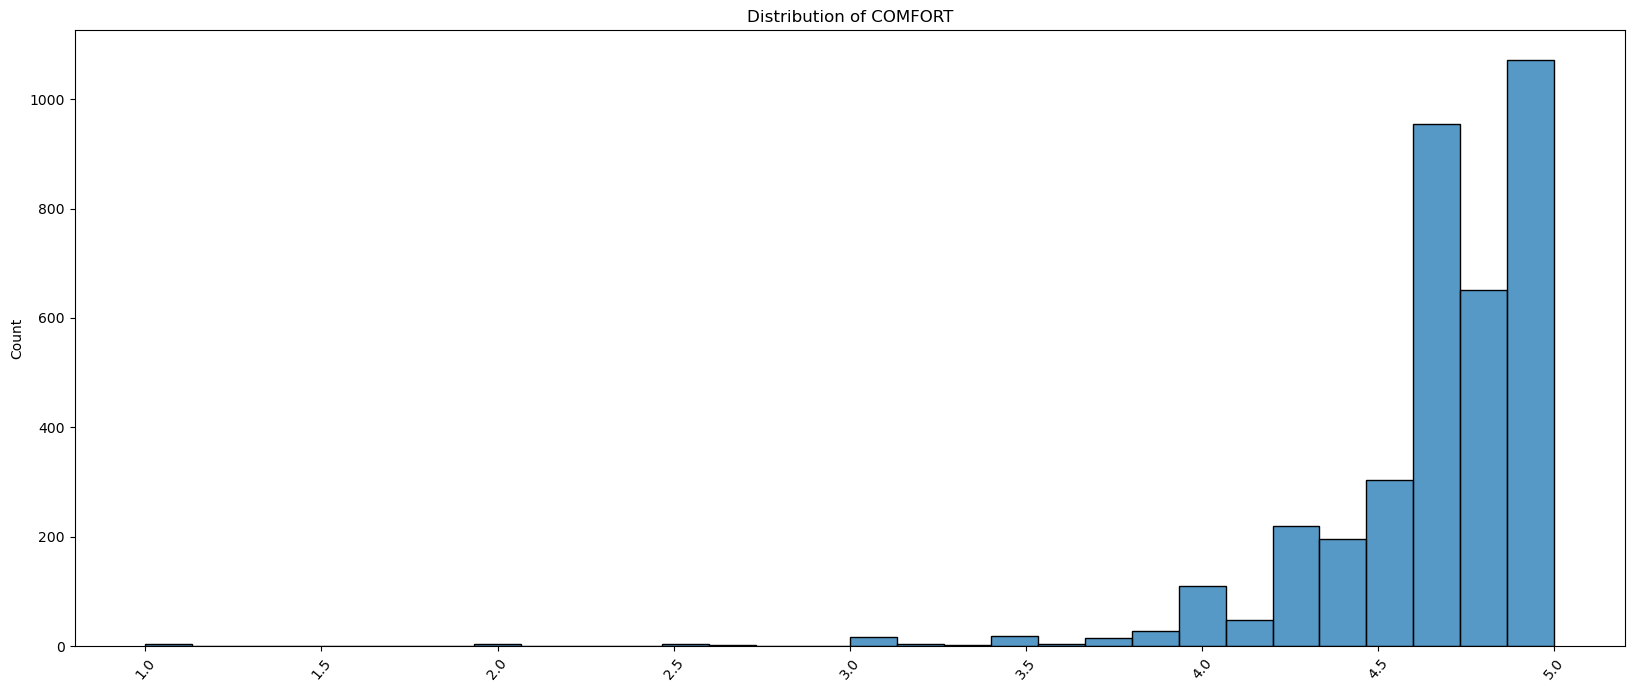

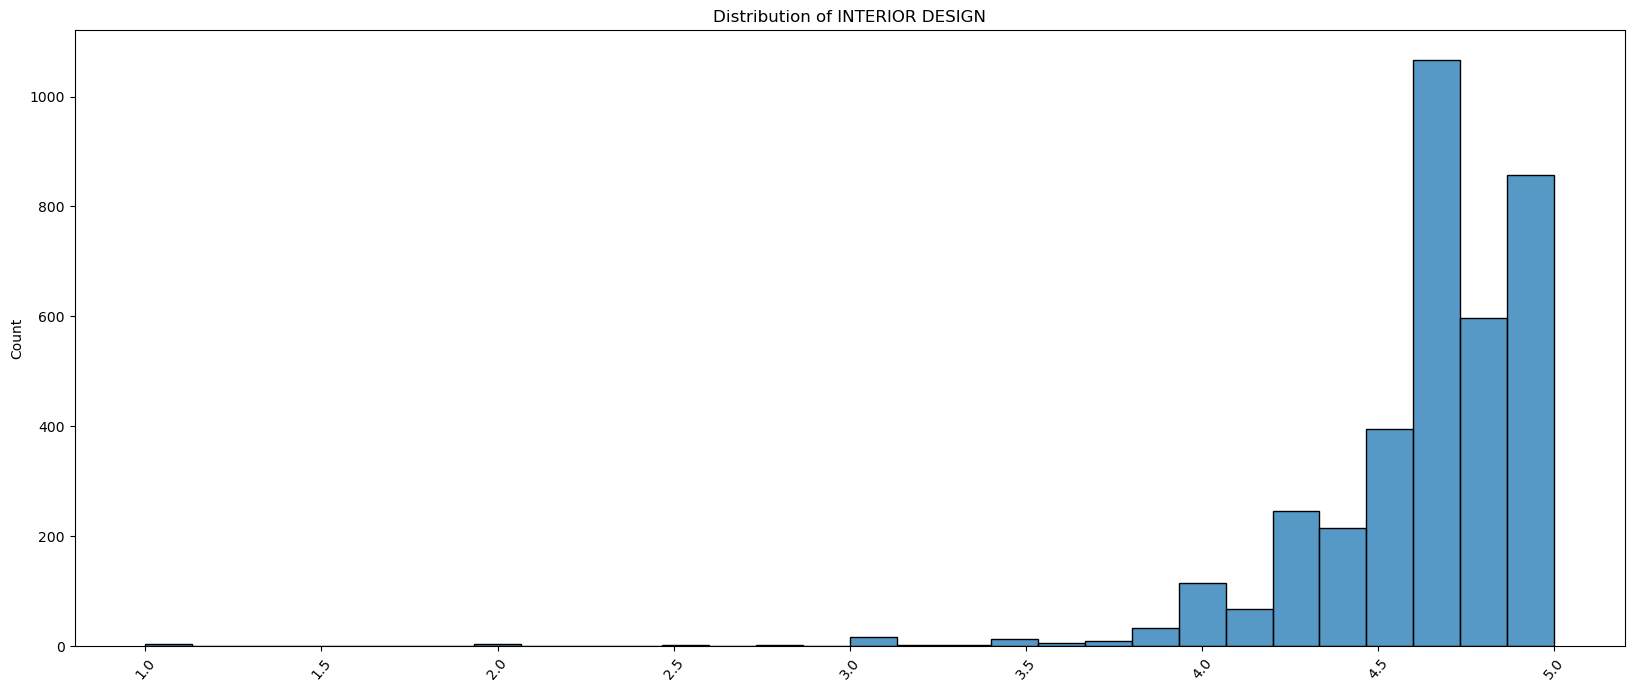

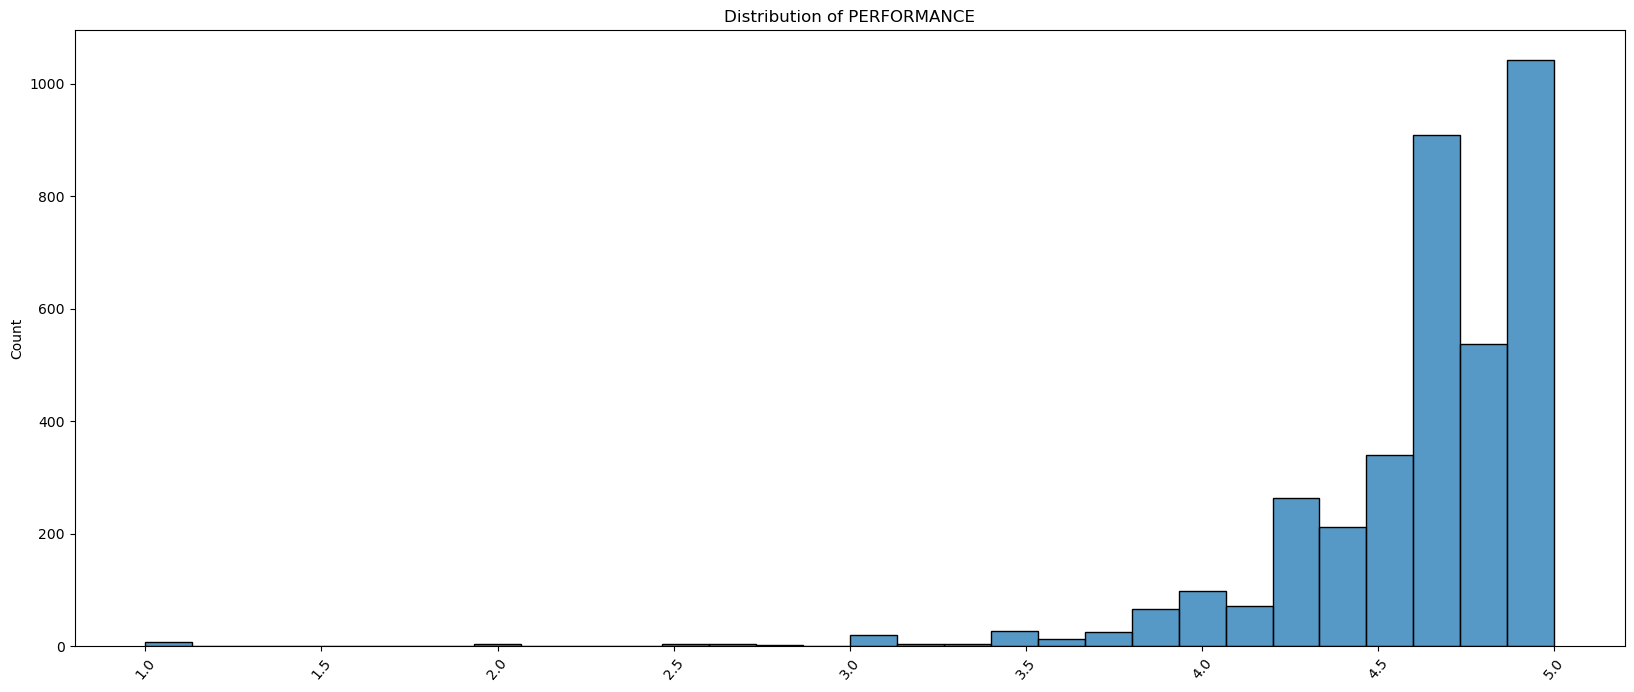

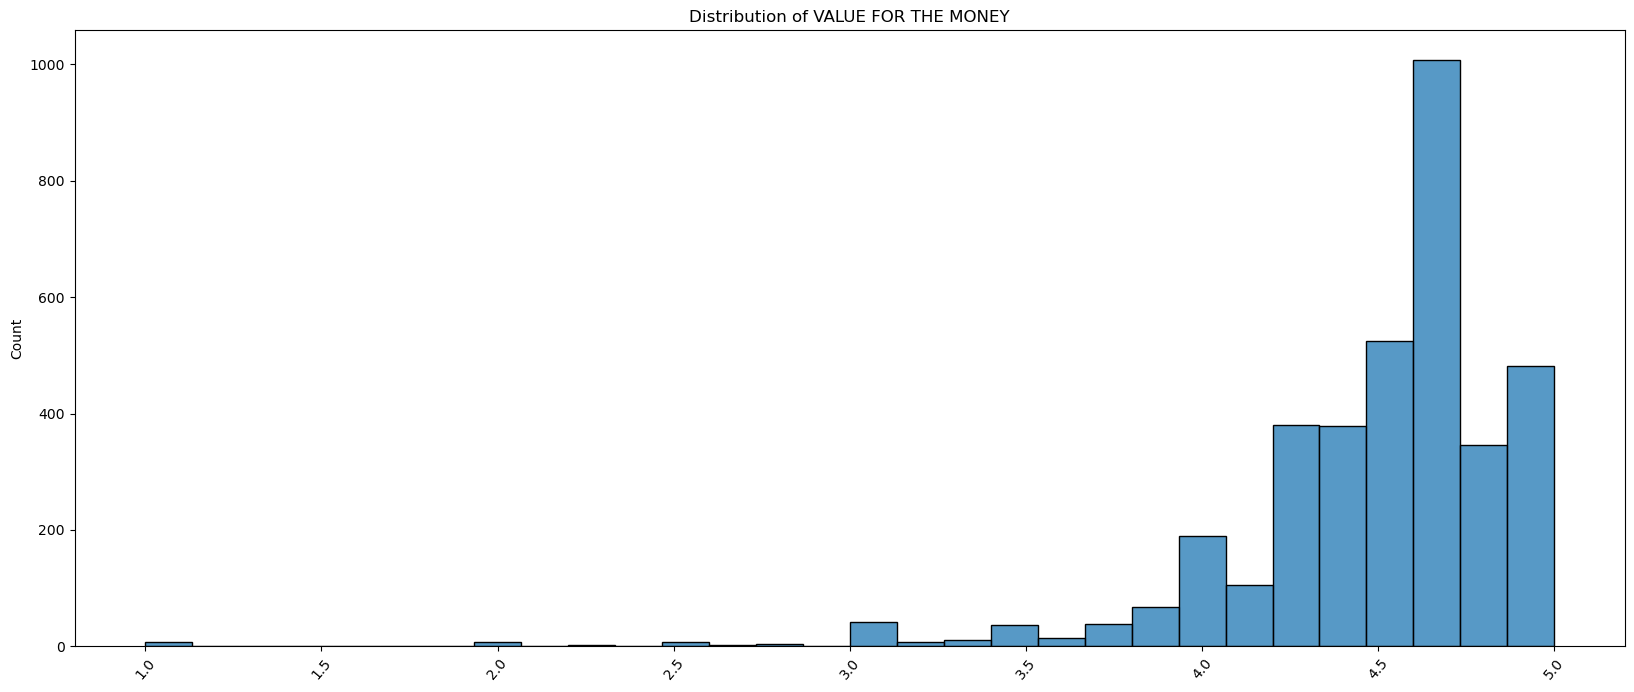

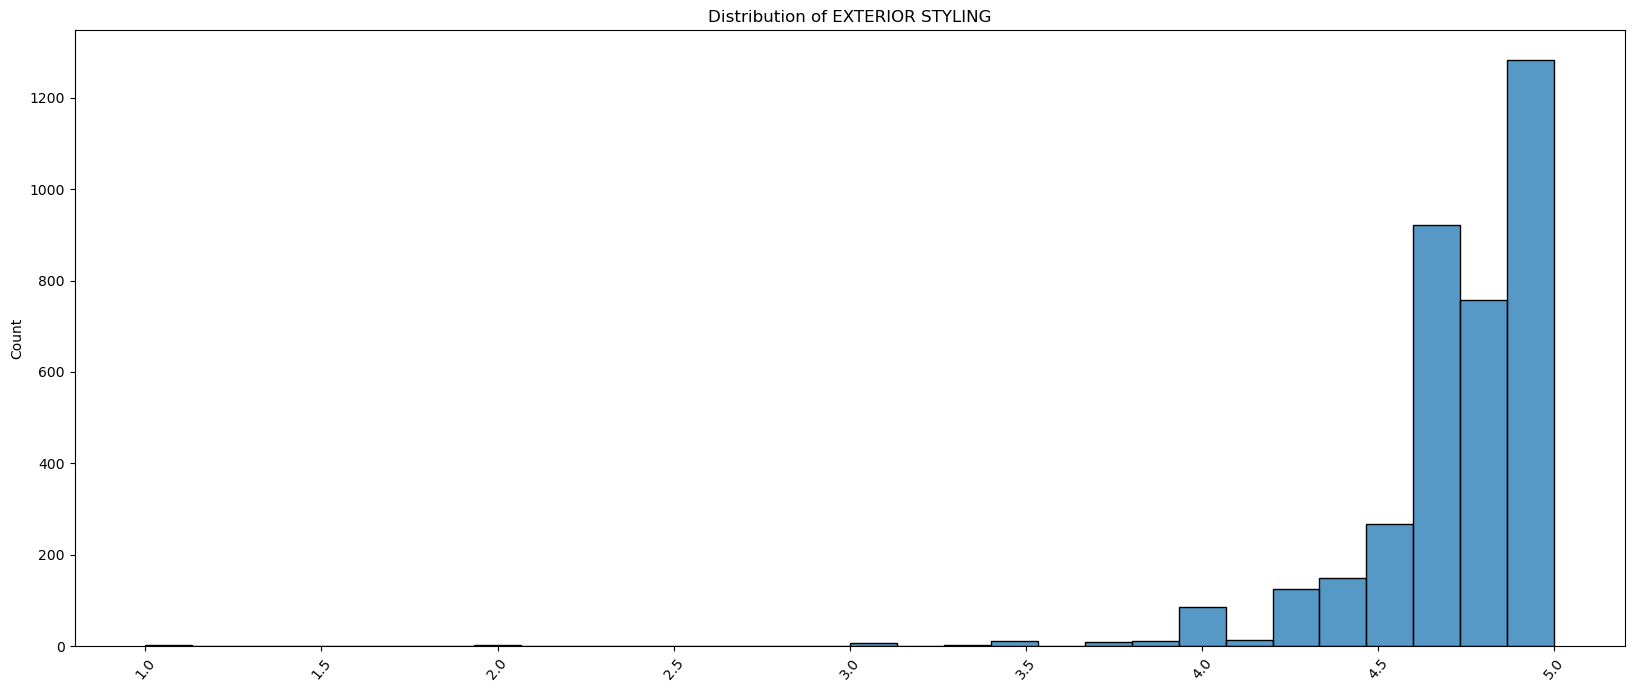

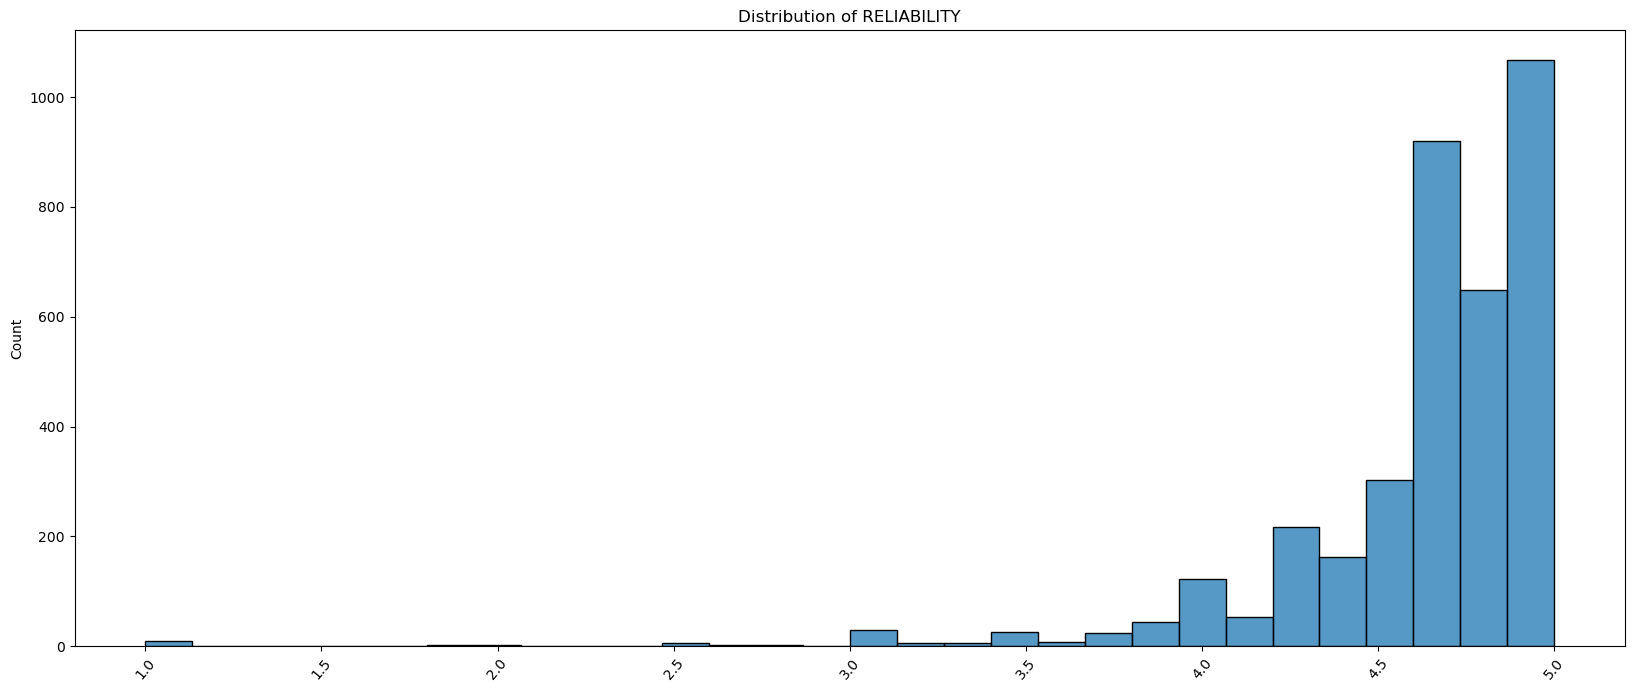

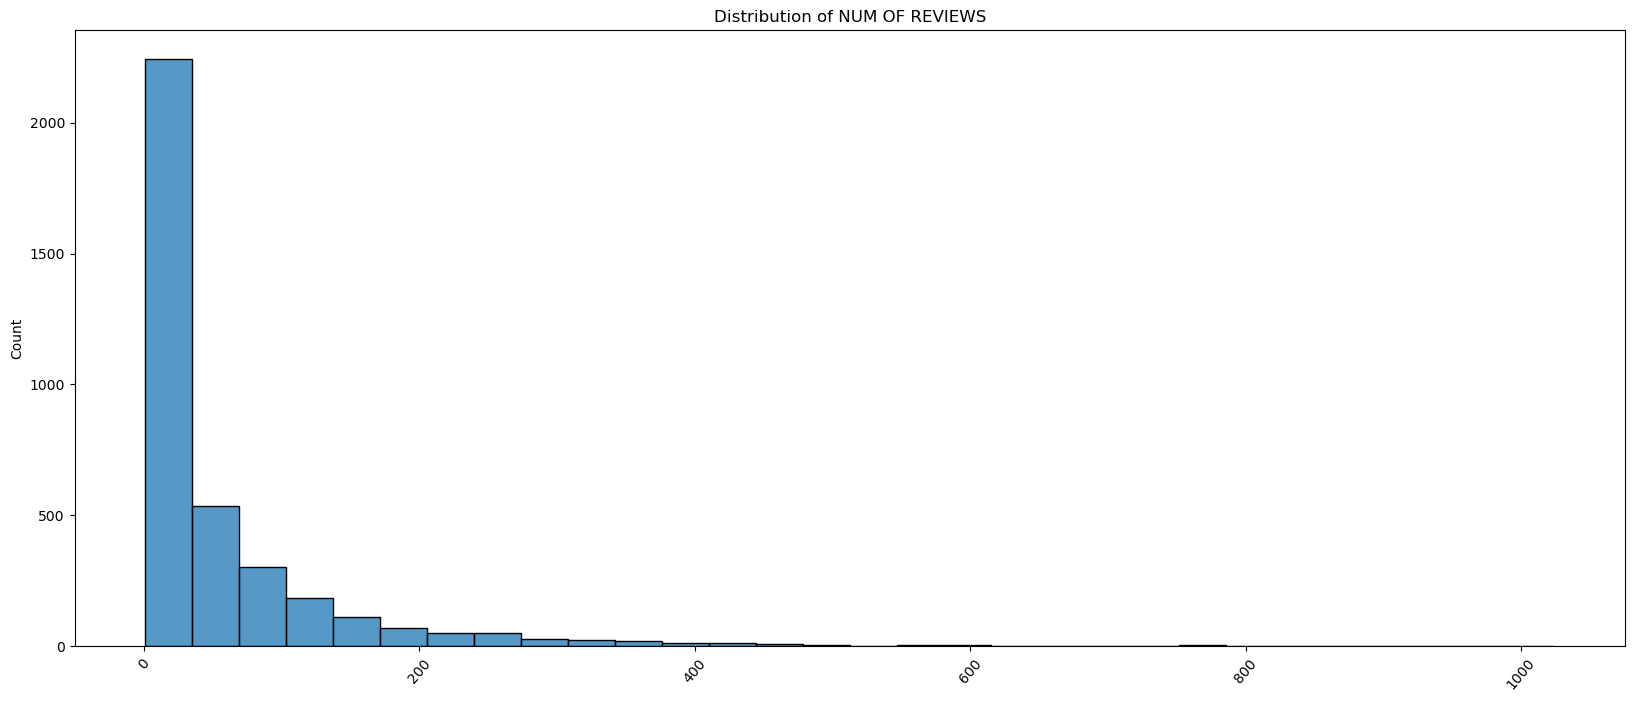

In [43]:
for col in numerical_cols:
    hist_plot(car_rates_sdf,col)

Insight:

The continuous variables are highly  skewed, with outliers. For highly skewed feature distributions, it is common practice to apply a logarithmic transformation on the data so that the tremendous and minimal values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. 

<a id="dataS4" ></a>
# Logarithmic Transformation

#### Log Transformation to handle skewness in continuous features.

In [4]:
car_rates_sdf=spark.read.csv(
    path="car_rates_modified.csv",
    header=True,
    inferSchema=True
)

In [5]:
car_rates_sdf.columns

['num_of_reviews',
 'comfort',
 'interior_design',
 'performance',
 'value_for_the_money',
 'exterior_styling',
 'reliability',
 'year',
 'brand',
 'model']

In [6]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import log1p

In [7]:
numerical_cols=skewed=["comfort","interior_design","performance","value_for_the_money","exterior_styling","reliability","num_of_reviews"]

In [8]:
for name in car_rates_sdf.schema.names:
    if name in numerical_cols:
        
        car_rates_sdf=car_rates_sdf.withColumn(
            name,log1p(col(name))
        )

In [51]:
car_rates_sdf.show(5)

+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+----+-----+--------+
|    num_of_reviews|           comfort|   interior_design|       performance|value_for_the_money|  exterior_styling|       reliability|year|brand|   model|
+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+----+-----+--------+
| 1.791759469228055|1.6863989535702286|1.6863989535702286|1.7227665977411035| 1.6486586255873816| 1.791759469228055|1.7578579175523736|2023|Acura|Integra.|
|1.3862943611198906| 1.667706820558076| 1.667706820558076|1.7404661748405044|  1.791759469228055| 1.791759469228055| 1.791759469228055|2022|Acura|    TLX.|
| 2.995732273553991|1.7578579175523736|1.7227665977411035|1.7404661748405044| 1.7227665977411035|1.7749523509116738|1.7227665977411035|2022|Acura|    MDX.|
|1.0986122886681096| 1.791759469228055| 1.791759469228055|1.7047

In [9]:
def hist_plot(data,col_name=""):
    plt.figure(figsize=(20,8))
    sns.histplot(x=np.array(data.select(col_name).rdd.flatMap(lambda x: x).collect()),bins=30)
    plt.title("Distribution of "+re.sub("_"," ",col_name.upper()))
    plt.xticks(rotation=50);

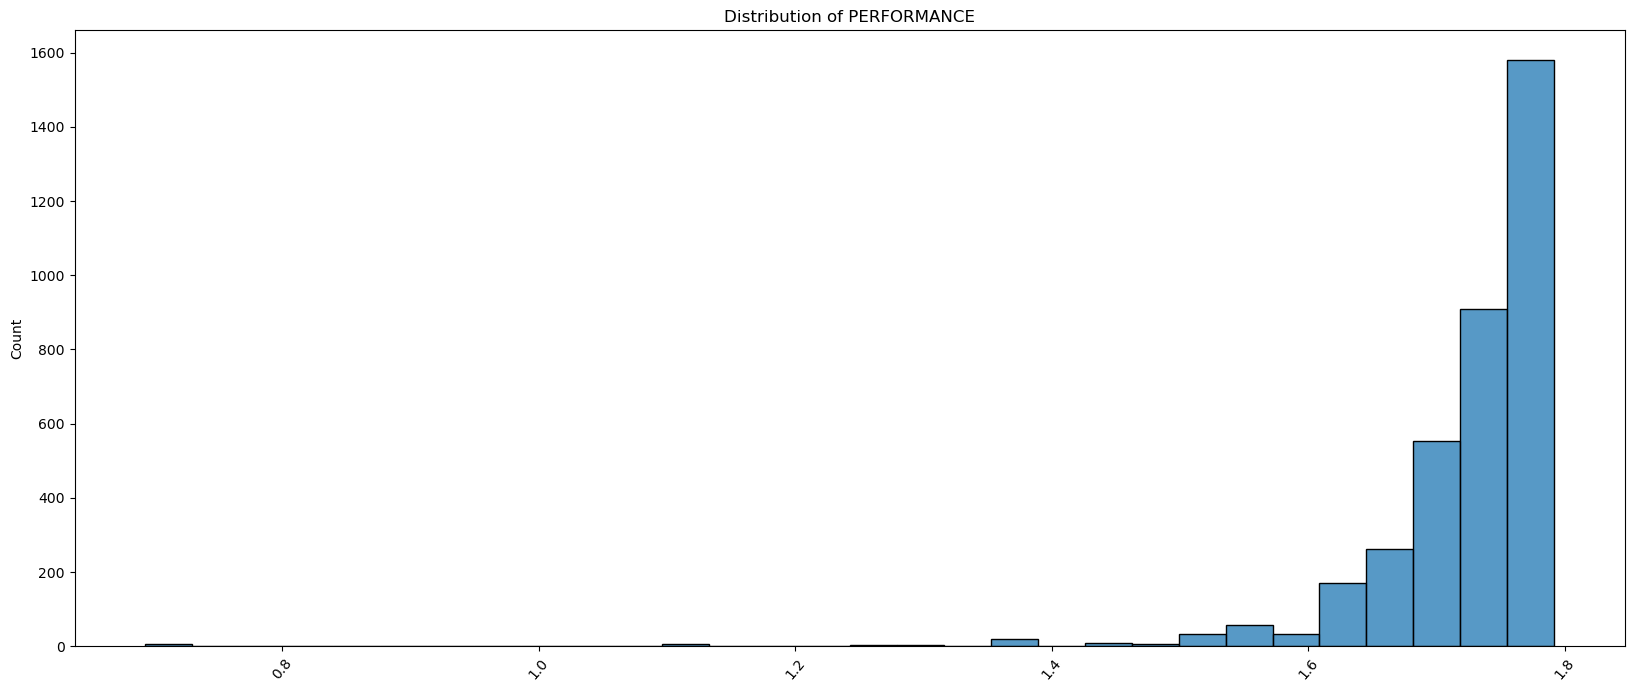

In [10]:
hist_plot(car_rates_sdf,"performance")

<a id="pre-process" ></a>
# Data Pre-Processing.

In [1]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer

In [22]:
features=['num_of_reviews',
                 'comfort',
                 'interior_design',
                 'performance',
                 'value_for_the_money',
                 'exterior_styling',
                 'reliability',
                 'year',
         'model_indexed'
]

In [23]:
features

['num_of_reviews',
 'comfort',
 'interior_design',
 'performance',
 'value_for_the_money',
 'exterior_styling',
 'reliability',
 'year',
 'model_indexed']

In [24]:
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")

In [25]:
car_rates_sdf=vector_assembler.transform(car_rates_sdf)

In [26]:
normalizer = Normalizer(inputCol="features",
outputCol="norm_features", p=1.0)
normalised_data = normalizer.transform(car_rates_sdf)
normalised_data.select('norm_features').show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|norm_features                                                                                                                                                                                 |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[8.776505816101291E-4,8.260422494461734E-4,8.260422494461734E-4,8.438560713382993E-4,8.075560511739394E-4,8.776505816101291E-4,8.610447162266095E-4,0.9909182326588879,0.0031619248402605963] |
|[6.798594213068892E-4,8.178682866590057E-4,8.178682866590057E-4,8.535505586817775E-4,8.787055549201473E-4,8.787055549201473E-4,8.787055549201473E-4,0.9916189435929216,0.002575793189011262]  |
|[0.001468377665266293,8.6162549558

In [27]:
normalised_data.columns

['num_of_reviews',
 'comfort',
 'interior_design',
 'performance',
 'value_for_the_money',
 'exterior_styling',
 'reliability',
 'year',
 'brand',
 'model',
 'model_indexed',
 'features',
 'norm_features']

In [28]:
indexer = StringIndexer(inputCol="brand", outputCol="brand_label") 

In [29]:
final_df = indexer.fit(normalised_data).transform(normalised_data)

In [30]:
final_df = final_df.withColumn("brand_label", col("brand_label").cast("int"))


In [31]:
final_df.select("brand","brand_label").show(5)

+-----+-----------+
|brand|brand_label|
+-----+-----------+
|Acura|         22|
|Acura|         22|
|Acura|         22|
|Acura|         22|
|Acura|         22|
+-----+-----------+
only showing top 5 rows



In [32]:
train, test = final_df.randomSplit([0.75, 0.25],seed = 42)

In [33]:
train.toPandas().to_csv("train_data_with_logT.csv",index=False)
test.toPandas().to_csv("test_data_with_logT.csv",index=False)

<a id="over" ></a>
# Oversampling 

As we have imbalanced data, we will try the oversampling technique to increase the number of observations in minor classes
based on the ratio between them and the major class.

In [34]:
# car_rates_sdf.groupBy("brand").count().orderBy('count',ascending=False)
train.groupBy("brand","brand_label").count().orderBy('count',ascending=False).show()

+-------------+-----------+-----+
|        brand|brand_label|count|
+-------------+-----------+-----+
|          BMW|          0|  271|
|Mercedes-Benz|          3|  193|
|       Toyota|          1|  183|
|         Ford|          2|  183|
|    Chevrolet|          4|  172|
|         Audi|          5|  167|
|       Nissan|          6|  149|
|        Lexus|          7|  139|
|      Hyundai|          8|  115|
|          Kia|          9|  107|
|        Honda|         10|   97|
|   Volkswagen|         11|   95|
|          GMC|         12|   79|
|       Subaru|         13|   78|
|        Volvo|         14|   72|
|     INFINITI|         17|   69|
|         Jeep|         16|   67|
|     Cadillac|         15|   65|
|        Mazda|         18|   62|
|      Porsche|         19|   58|
+-------------+-----------+-----+
only showing top 20 rows



In [35]:
from pyspark.sql.functions import explode , array , lit

In [36]:
from functools import reduce
import pyspark
def create_oversampling_dfs(df,col_name,major_class,minor_classes_list):
    major_df = df.filter(col(col_name) == major_class)
    oversampled_df=None
    dfs_list=[]
    for i,v in enumerate(minor_classes_list):
        minor_df=df.filter(col(col_name) == v)
        ratio=int(major_df.count()/minor_df.count())
        a = range(ratio)
        oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop("dummy")
        
        dfs_list.append(oversampled_df)
        oversampled_df = reduce(pyspark.sql.dataframe.DataFrame.unionByName, dfs_list)
    combined_df = major_df.unionAll(oversampled_df)
    return combined_df
        
    
    

In [13]:
# train.count()

In [37]:
minor_classes_list=list(range(1,29))

In [38]:
import time
start = time.process_time()
oversampled_df=create_oversampling_dfs(train,"brand_label",0,minor_classes_list)
print(f"It took: {time.process_time() - start//60} minutes")

It took: 226.4310133 minutes


In [40]:
print(f"It took: {226.4310133//60} minutes")

It took: 3.0 minutes


In [41]:
oversampled_df.groupBy("brand","brand_label").count().orderBy('count',ascending=False).show()

+----------+-----------+-----+
|     brand|brand_label|count|
+----------+-----------+-----+
|       BMW|          0|  271|
|      Land|         25|  270|
|      Jeep|         16|  268|
|    Jaguar|         27|  264|
|  Cadillac|         15|  260|
|  Chrysler|         28|  256|
|Mitsubishi|         26|  252|
|     Mazda|         18|  248|
|     Acura|         22|  245|
|     Dodge|         21|  240|
|       GMC|         12|  237|
|   Lincoln|         20|  235|
|    Subaru|         13|  234|
|       RAM|         24|  234|
|   Porsche|         19|  232|
|   Hyundai|          8|  230|
|     Buick|         23|  230|
|     Volvo|         14|  216|
|       Kia|          9|  214|
|  INFINITI|         17|  207|
+----------+-----------+-----+
only showing top 20 rows



In [26]:
print(f"Number of observations without oversampling: {train.count()}\nNumber of observations with oversampling: {oversampled_df.count()}")

Number of observations without oversampling: 2794
Number of observations with oversampling: 6413


In [42]:
brands_value_count_without_oversampling=train.groupBy("brand").count().orderBy('count',ascending=False)
brands_value_count_without_oversampling=brands_value_count_without_oversampling.toPandas()
brands_value_count_with_oversampling=oversampled_df.groupBy("brand").count().orderBy('count',ascending=False)
brands_value_count_with_oversampling=brands_value_count_with_oversampling.toPandas()

In [43]:
def bar_plot(df,x="",y="",x_name="",y_name="",title=""):
        
    plt.figure(figsize=(20,8))
    sns.barplot(x=df[x],y=df[y])
    plt.xlabel(x_name.upper())
    plt.ylabel(y_name.upper())
    plt.title(title.upper())
    plt.xticks(rotation=50);

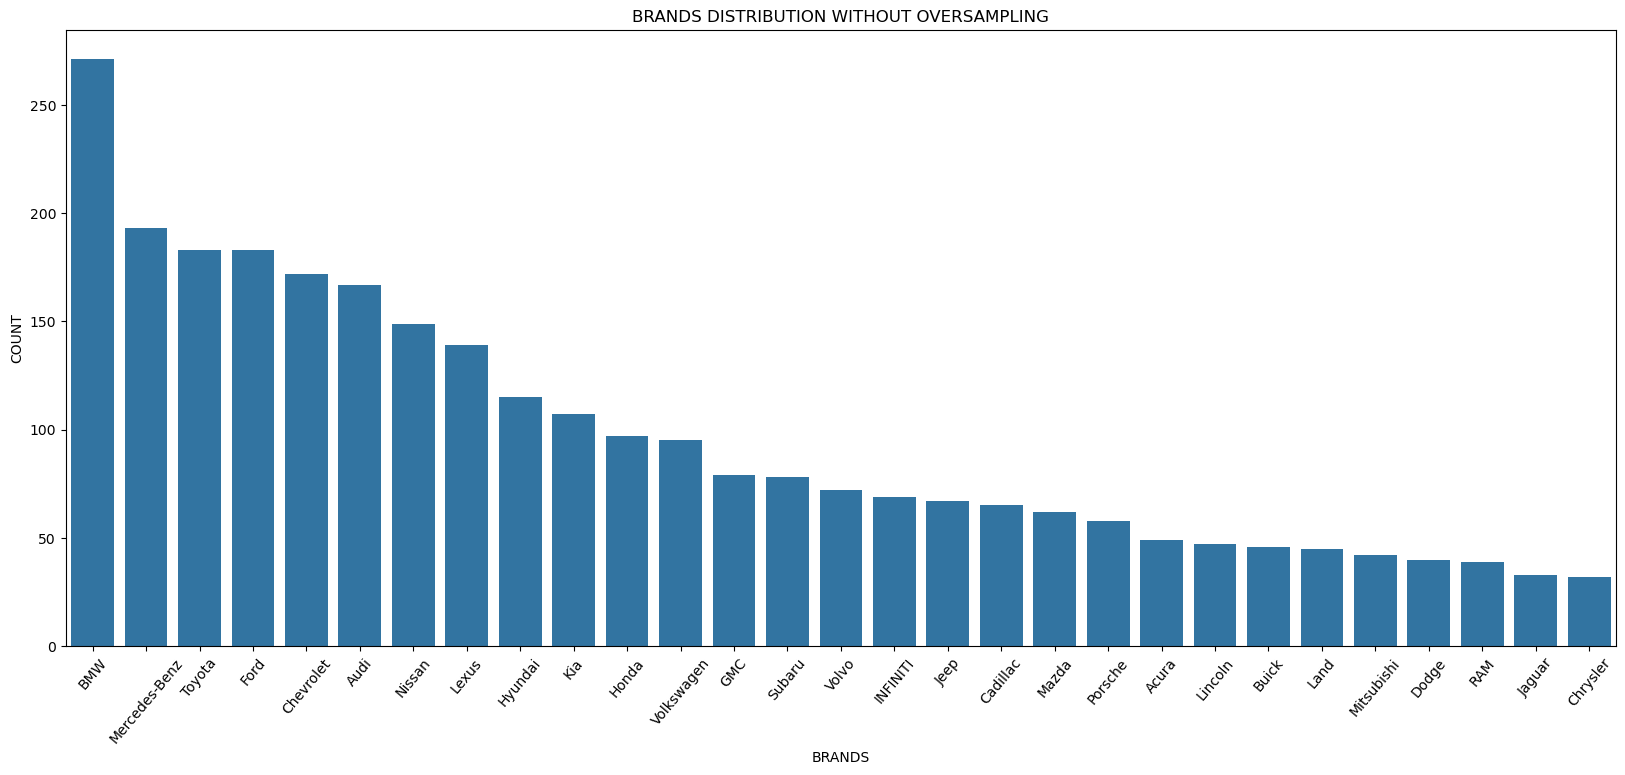

In [44]:
bar_plot(brands_value_count_without_oversampling,"brand","count","brands","count","brands distribution without oversampling")

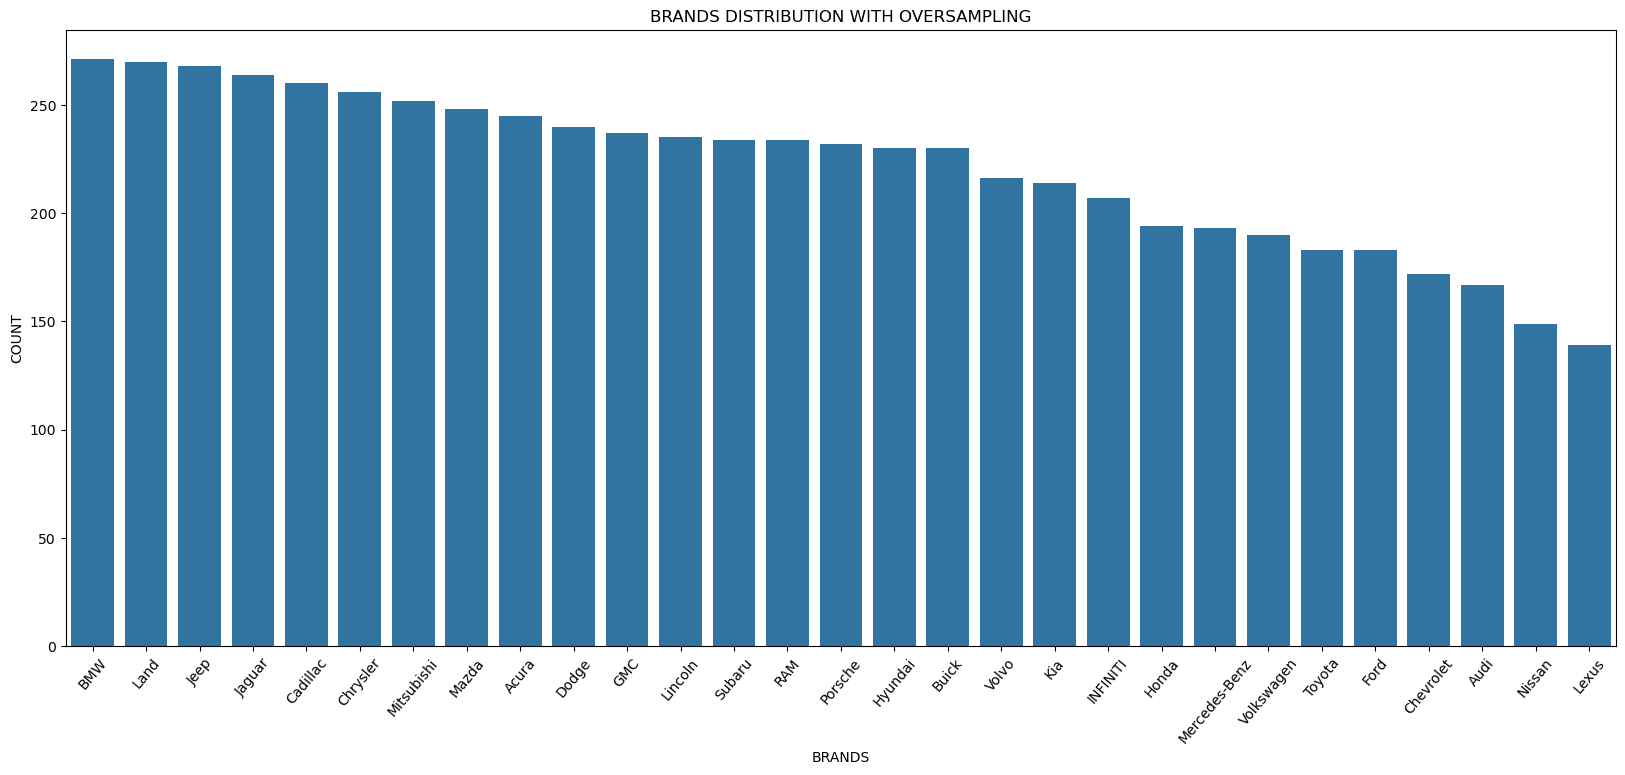

In [45]:
bar_plot(brands_value_count_with_oversampling,"brand","count","brands","count","brands distribution with oversampling")

In [46]:
#save oversampled_data
oversampled_df.toPandas().to_csv("oversampled_data_with_logT.csv",index=False)

<a id="modeling" ></a>
# Data Modeling

<a id="multiC" ></a>
### MultiClass Classification

In [1]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import OneVsRest, LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', None)
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import re

In [3]:
SparkSession.getActiveSession()

In [4]:
spark = SparkSession.builder \
    .master("local")\
    .appName("Car Ratings Classification Project2") \
    .getOrCreate()

In [5]:
#load the data
train=spark.read.csv(
    path="train_data_with_logT.csv",
    header=True,
    inferSchema=True
)
test=spark.read.csv(
    path="test_data_with_logT.csv",
    header=True,
    inferSchema=True
)

oversampled_df=spark.read.csv(
    path="oversampled_data_with_logT.csv",
    header=True,
    inferSchema=True
)

In [6]:
print("Most frequent car brand in train data")
display(train.groupBy("brand").count().orderBy('count',ascending=False).show())
print("-"*50)
print("Most frequent car brand in test data")
display(test.groupBy("brand").count().orderBy('count',ascending=False).show())
print("-"*50)
print("Most frequent car brand in oversampled data")
display(oversampled_df.groupBy("brand").count().orderBy('count',ascending=False).show())
print("-"*50)

Most frequent car brand in train data
+-------------+-----+
|        brand|count|
+-------------+-----+
|          BMW|  271|
|Mercedes-Benz|  193|
|       Toyota|  183|
|         Ford|  183|
|    Chevrolet|  172|
|         Audi|  167|
|       Nissan|  149|
|        Lexus|  139|
|      Hyundai|  115|
|          Kia|  107|
|        Honda|   97|
|   Volkswagen|   95|
|          GMC|   79|
|       Subaru|   78|
|        Volvo|   72|
|     INFINITI|   69|
|         Jeep|   67|
|     Cadillac|   65|
|        Mazda|   62|
|      Porsche|   58|
+-------------+-----+
only showing top 20 rows



None

--------------------------------------------------
Most frequent car brand in test data
+-------------+-----+
|        brand|count|
+-------------+-----+
|          BMW|   71|
|       Toyota|   64|
|         Ford|   59|
|       Nissan|   56|
|    Chevrolet|   52|
|Mercedes-Benz|   48|
|         Audi|   44|
|        Lexus|   42|
|      Hyundai|   40|
|          Kia|   33|
|        Honda|   32|
|   Volkswagen|   27|
|      Lincoln|   24|
|        Dodge|   24|
|          RAM|   23|
|     Cadillac|   23|
|          GMC|   23|
|         Jeep|   20|
|        Volvo|   18|
|        Mazda|   17|
+-------------+-----+
only showing top 20 rows



None

--------------------------------------------------
Most frequent car brand in oversampled data
+----------+-----+
|     brand|count|
+----------+-----+
|       BMW|  271|
|      Land|  270|
|      Jeep|  268|
|    Jaguar|  264|
|  Cadillac|  260|
|  Chrysler|  256|
|Mitsubishi|  252|
|     Mazda|  248|
|     Acura|  245|
|     Dodge|  240|
|       GMC|  237|
|   Lincoln|  235|
|       RAM|  234|
|    Subaru|  234|
|   Porsche|  232|
|   Hyundai|  230|
|     Buick|  230|
|     Volvo|  216|
|       Kia|  214|
|  INFINITI|  207|
+----------+-----+
only showing top 20 rows



None

--------------------------------------------------


In [7]:
#train models without ["model"] variable, because it has a high correlation with the brand "our Y variable".
features=['num_of_reviews',
                 'comfort',
                 'interior_design',
                 'performance',
                 'value_for_the_money',
                 'exterior_styling',
                 'reliability',
                 'year',
]
vector_assembler = VectorAssembler(inputCols=features, outputCol="input_features")
train=vector_assembler.transform(train)
test=vector_assembler.transform(test)
oversampled_df=vector_assembler.transform(oversampled_df)

<a id="multiCa" ></a>
### Random Forest

In [8]:
rf=RandomForestClassifier(featuresCol="input_features",labelCol="brand_label",numTrees=50)

In [9]:
import time
start = time.process_time()
rf_model=rf.fit(train)
time_sec=time.process_time() - start
print(f"It took: {time_sec//60} minutes")

It took: 0.0 minutes


#### How the model performs on "Training Data"?

In [10]:
training_predictions=rf_model.transform(train)

In [11]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(training_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(training_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(training_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.17145151420850652 
Accuracy: 0.2394
Area Under the Curve (AUC): 0.75293060302779 


In [12]:
rf_model.featureImportances

SparseVector(8, {0: 0.1865, 1: 0.061, 2: 0.1261, 3: 0.1622, 4: 0.1368, 5: 0.0722, 6: 0.1792, 7: 0.0759})

## Confution Matrix

In [13]:
from pyspark.ml.feature import IndexToString
from pyspark.ml.feature import StringIndexer, StringIndexerModel

# indexer = StringIndexer(inputCol="brand", outputCol="brand_label2").fit(training_predictions)
# indexer.save("string_indexer2")
indexer = StringIndexerModel.load("string_indexer2")

In [14]:
indexer.labels

['BMW',
 'Mercedes-Benz',
 'Ford',
 'Toyota',
 'Chevrolet',
 'Audi',
 'Nissan',
 'Lexus',
 'Hyundai',
 'Kia',
 'Honda',
 'Volkswagen',
 'GMC',
 'Subaru',
 'Volvo',
 'INFINITI',
 'Jeep',
 'Cadillac',
 'Mazda',
 'Porsche',
 'Acura',
 'Lincoln',
 'Buick',
 'Land',
 'Mitsubishi',
 'Dodge',
 'RAM',
 'Jaguar',
 'Chrysler']

In [15]:
inverter = IndexToString(inputCol="prediction", outputCol="prediction_label",labels=indexer.labels)

In [16]:
training_predictions=inverter.transform(training_predictions)

In [17]:
training_predictions.select("brand","prediction_label","brand_label","prediction").show(5)

+--------+----------------+-----------+----------+
|   brand|prediction_label|brand_label|prediction|
+--------+----------------+-----------+----------+
|     GMC|          Nissan|         12|       6.0|
|     GMC|          Toyota|         12|       3.0|
|     BMW|          Nissan|          0|       6.0|
|INFINITI|   Mercedes-Benz|         17|       1.0|
|  Nissan|      Mitsubishi|          6|      24.0|
+--------+----------------+-----------+----------+
only showing top 5 rows



In [18]:
training_predictions.filter(training_predictions["brand"]=="BMW").filter(training_predictions["prediction_label"]=="BMW").\
select("brand","prediction_label","brand_label","prediction").show(5)

+-----+----------------+-----------+----------+
|brand|prediction_label|brand_label|prediction|
+-----+----------------+-----------+----------+
|  BMW|             BMW|          0|       0.0|
|  BMW|             BMW|          0|       0.0|
|  BMW|             BMW|          0|       0.0|
|  BMW|             BMW|          0|       0.0|
|  BMW|             BMW|          0|       0.0|
+-----+----------------+-----------+----------+
only showing top 5 rows



In [19]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

In [20]:
class_temp = training_predictions.select("brand").groupBy("brand").count().sort('count', ascending=False).toPandas()
class_names = class_temp["brand"].values.tolist()

In [21]:
class_names

['BMW',
 'Mercedes-Benz',
 'Toyota',
 'Ford',
 'Chevrolet',
 'Audi',
 'Nissan',
 'Lexus',
 'Hyundai',
 'Kia',
 'Honda',
 'Volkswagen',
 'GMC',
 'Subaru',
 'Volvo',
 'INFINITI',
 'Jeep',
 'Cadillac',
 'Mazda',
 'Porsche',
 'Acura',
 'Lincoln',
 'Buick',
 'Land',
 'Mitsubishi',
 'Dodge',
 'RAM',
 'Jaguar',
 'Chrysler']

In [22]:
from sklearn.metrics import confusion_matrix
y_true = training_predictions.select("brand")
y_true = y_true.toPandas()
y_pred = training_predictions.select("prediction_label")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[234,   7,   4,  15,   2,   0,   1,   8,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [118,   6,  43,  12,   7,   0,   2,   5,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 25, 119,   0,  15,   6,   0,   2,  11,   0,   3,   2,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 42,  22,   5,  84,  16,   0,   4,   9,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 42,  22,   6,  38,  53,   0,   4,   6,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [125,   7,   9,  11,   1,   2,   1,  11,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
    

Confusion matrix, without normalization


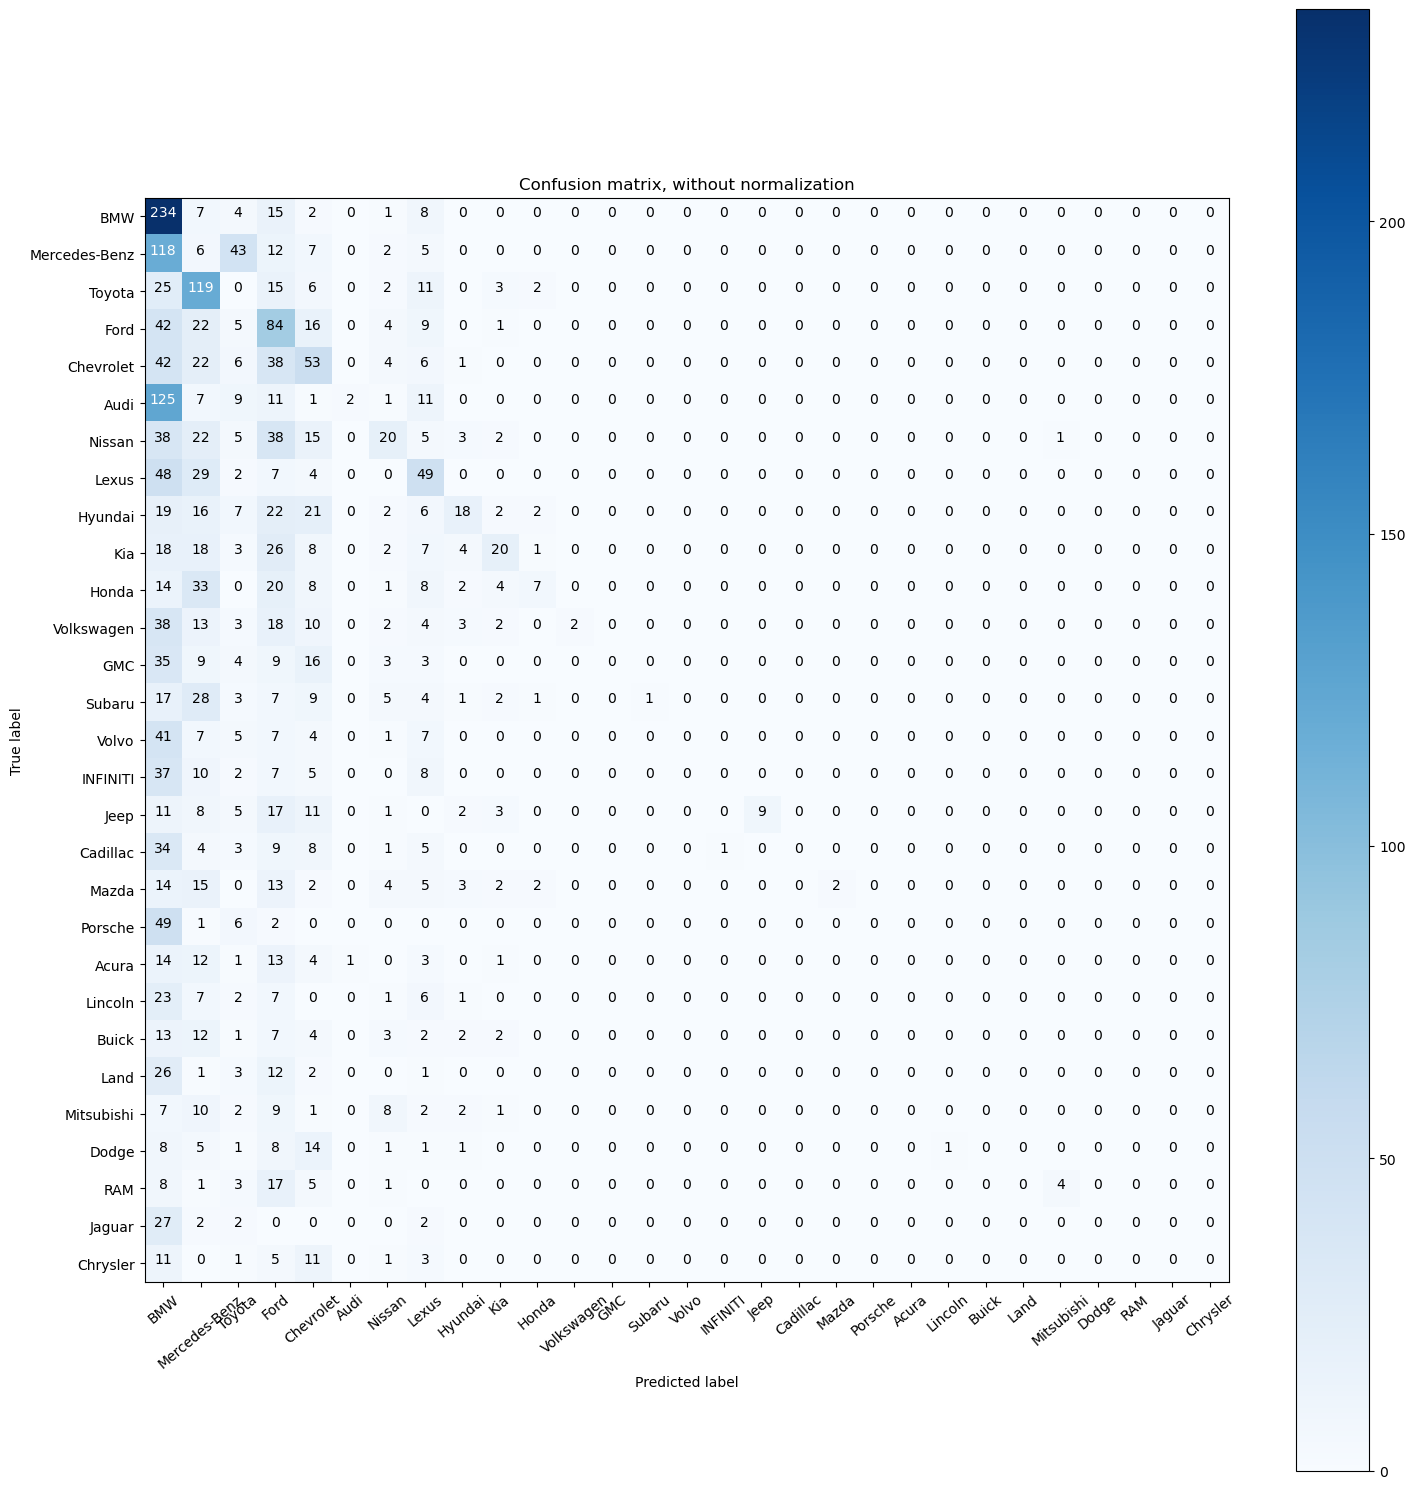

In [23]:
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show();

#### How the model performs on "Test Data".

In [24]:
model_predictions = rf_model.transform(test)

In [25]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(model_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(model_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(model_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.10978222567269297 
Accuracy: 0.1864
Area Under the Curve (AUC): 0.7655317872145152 


In [26]:
def invert_indexedlabel_to_string(df,classes_names):
    inverter = IndexToString(inputCol="prediction", outputCol="prediction_label",labels=classes_names)
    df=inverter.transform(df)
    return df
def confusion_matrics(df):
    y_true = df.select("brand")
    y_true = y_true.toPandas()
    y_pred = df.select("prediction_label")
    y_pred = y_pred.toPandas()
    cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
    return cnf_matrix

In [27]:
model_predictions=invert_indexedlabel_to_string(model_predictions,indexer.labels)
cnf_matrix=confusion_matrics(model_predictions)

Confusion matrix, without normalization


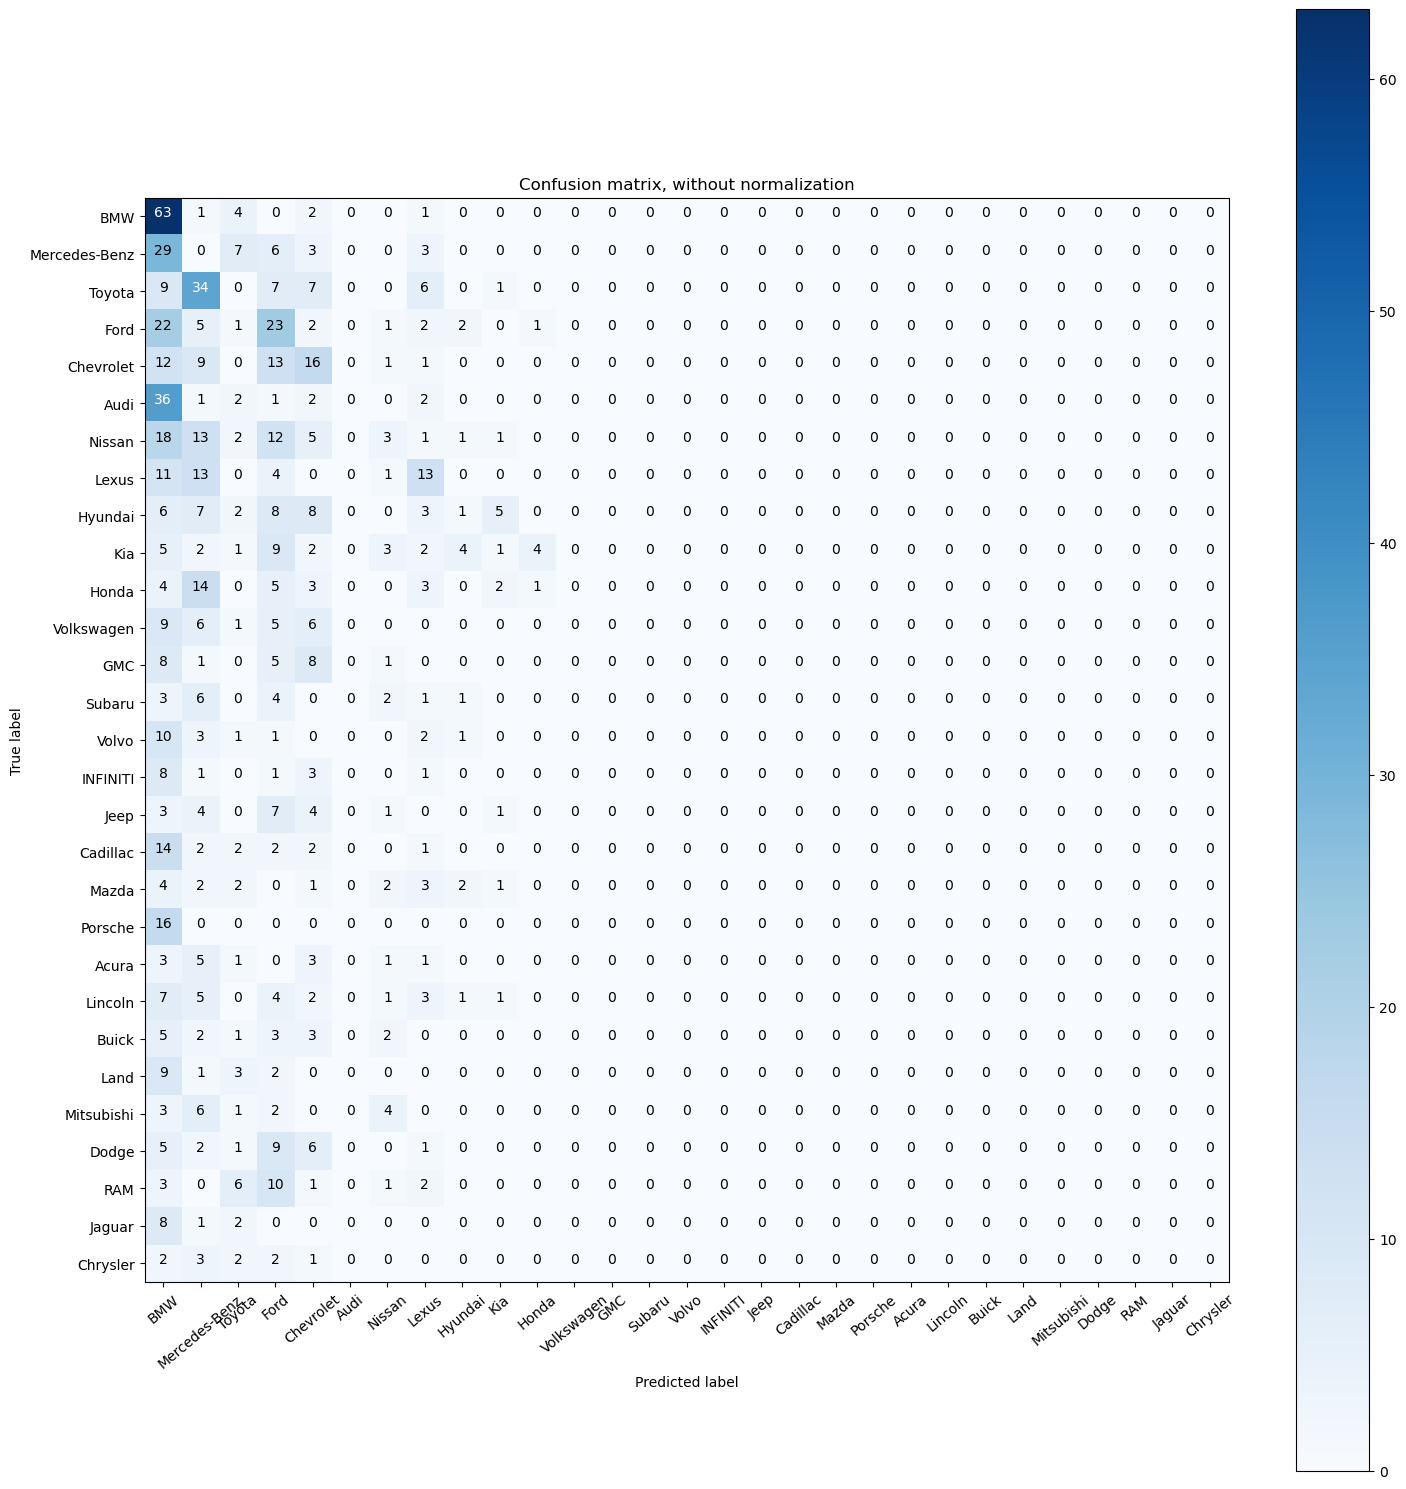

In [28]:
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show();

<a id="multiCb" ></a>
### Random Forest with oversampled data

In [29]:
start = time.process_time()
rf_model_over=rf.fit(oversampled_df)
time_sec=time.process_time() - start
print(f"It took: {time_sec//60} minutes")

It took: 0.0 minutes


In [30]:
oversampled_training_pred=rf_model_over.transform(oversampled_df)

##### Train's metrics.

In [31]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(oversampled_training_pred)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(oversampled_training_pred)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(oversampled_training_pred)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.24751362415307843 
Accuracy: 0.3105
Area Under the Curve (AUC): 0.48580579423508335 


Confusion matrix, without normalization


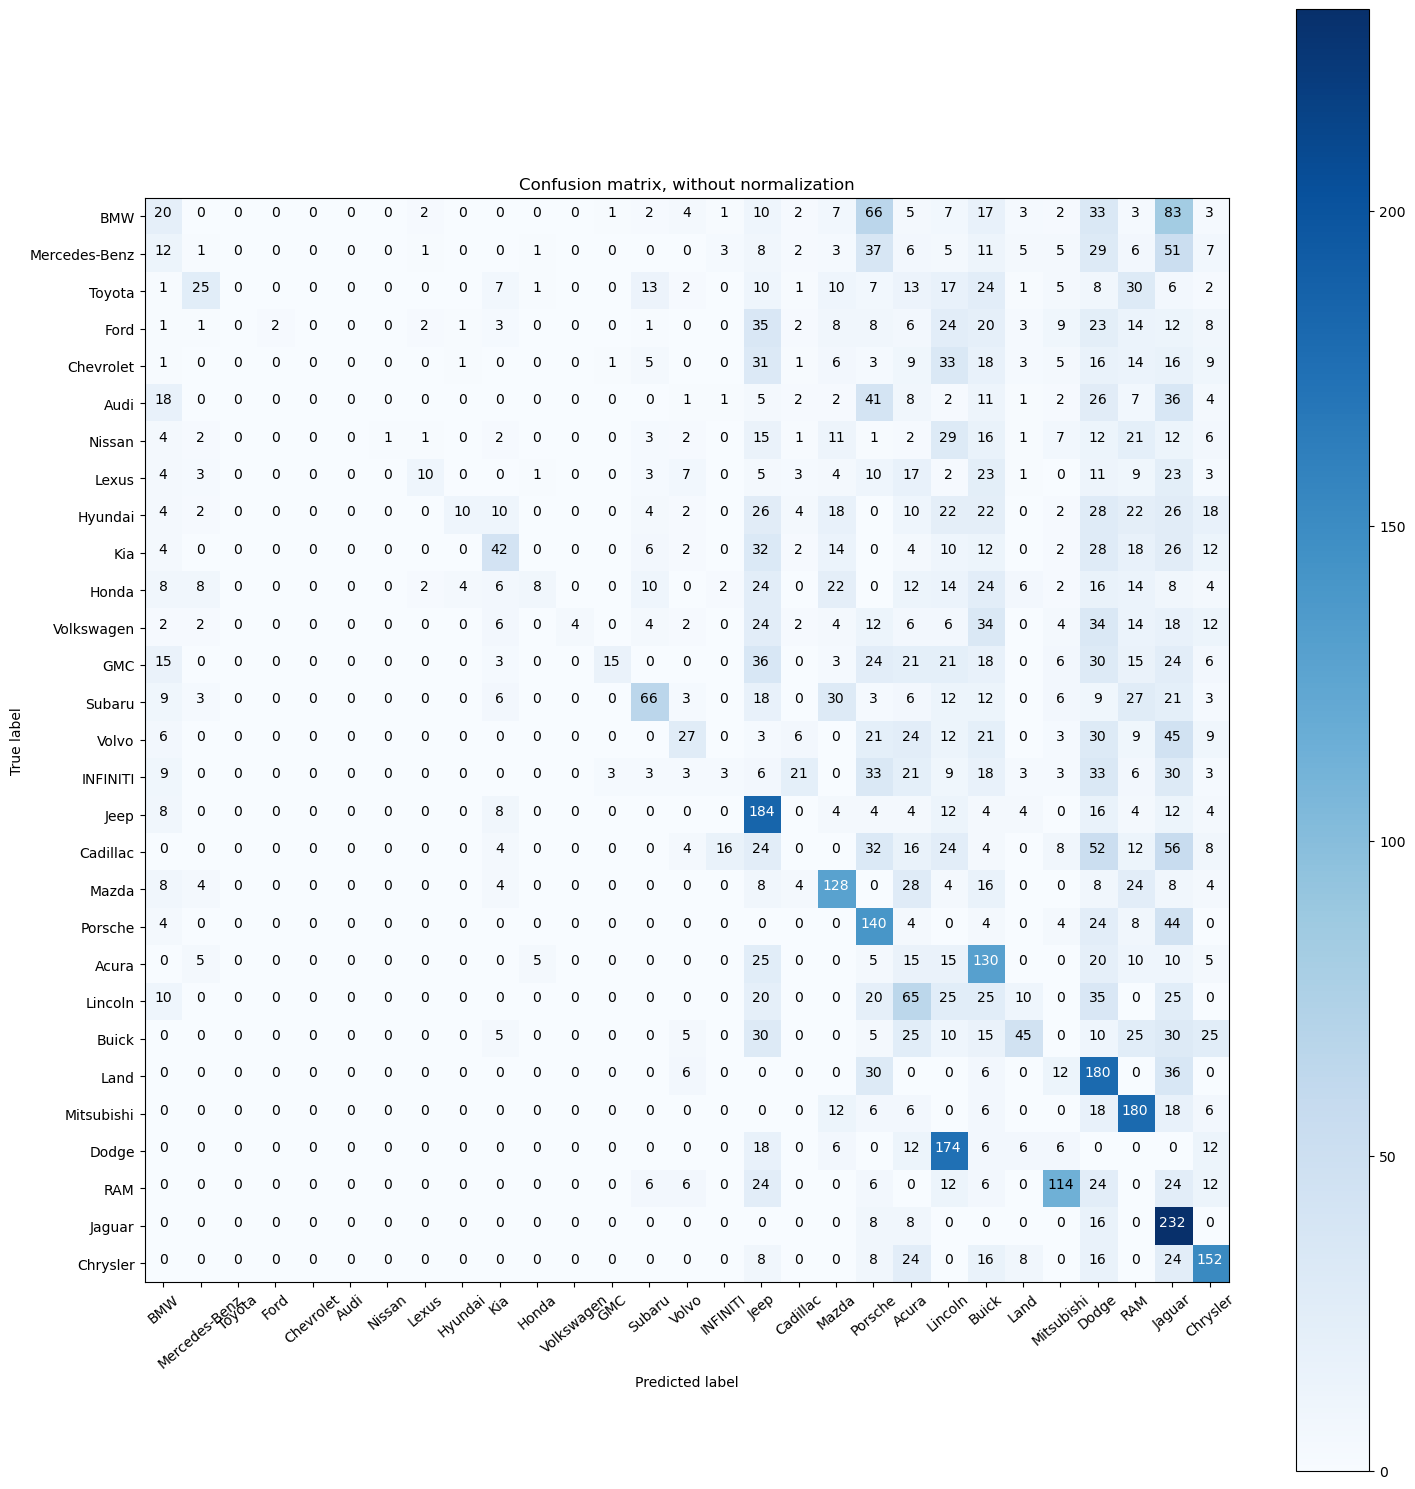

In [32]:
oversampled_training_pred=invert_indexedlabel_to_string(oversampled_training_pred,indexer.labels)
cnf_matrix=confusion_matrics(oversampled_training_pred)
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show();

### Insight:
 * Oversampling involves duplicating samples from the under-represented class to balance the class distribution, but rather than helping improve the    classification algorithms, it reduces the weight of other classes, and only gives weight to the minor classes. 


##### Test's Metrics.

In [33]:
model_predictions2 = rf_model_over.transform(test)

In [34]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(model_predictions2)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(model_predictions2)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(model_predictions2)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.06186891059855451 
Accuracy: 0.0806
Area Under the Curve (AUC): 0.46306788097003077 


<a id="multiCc" ></a>
### Logistic regression

In [35]:
log_reg=LogisticRegression(featuresCol="input_features",labelCol="brand_label")

In [36]:
start = time.process_time()
log_reg_training=log_reg.fit(train)
time_sec=time.process_time() - start
print(f"It took: {time_sec//60} minutes")

It took: 0.0 minutes


In [37]:
log_reg_training_pred=log_reg_training.transform(train)

In [38]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(log_reg_training_pred)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(log_reg_training_pred)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(log_reg_training_pred)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.13459926012070572 
Accuracy: 0.1936
Area Under the Curve (AUC): 0.7087115877104074 


In [39]:
log_reg_test_pred=log_reg_training.transform(test)

In [40]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(log_reg_test_pred)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(log_reg_test_pred)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(log_reg_test_pred)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.11529697302782259 
Accuracy: 0.1726
Area Under the Curve (AUC): 0.729570404885453 


Confusion matrix, without normalization


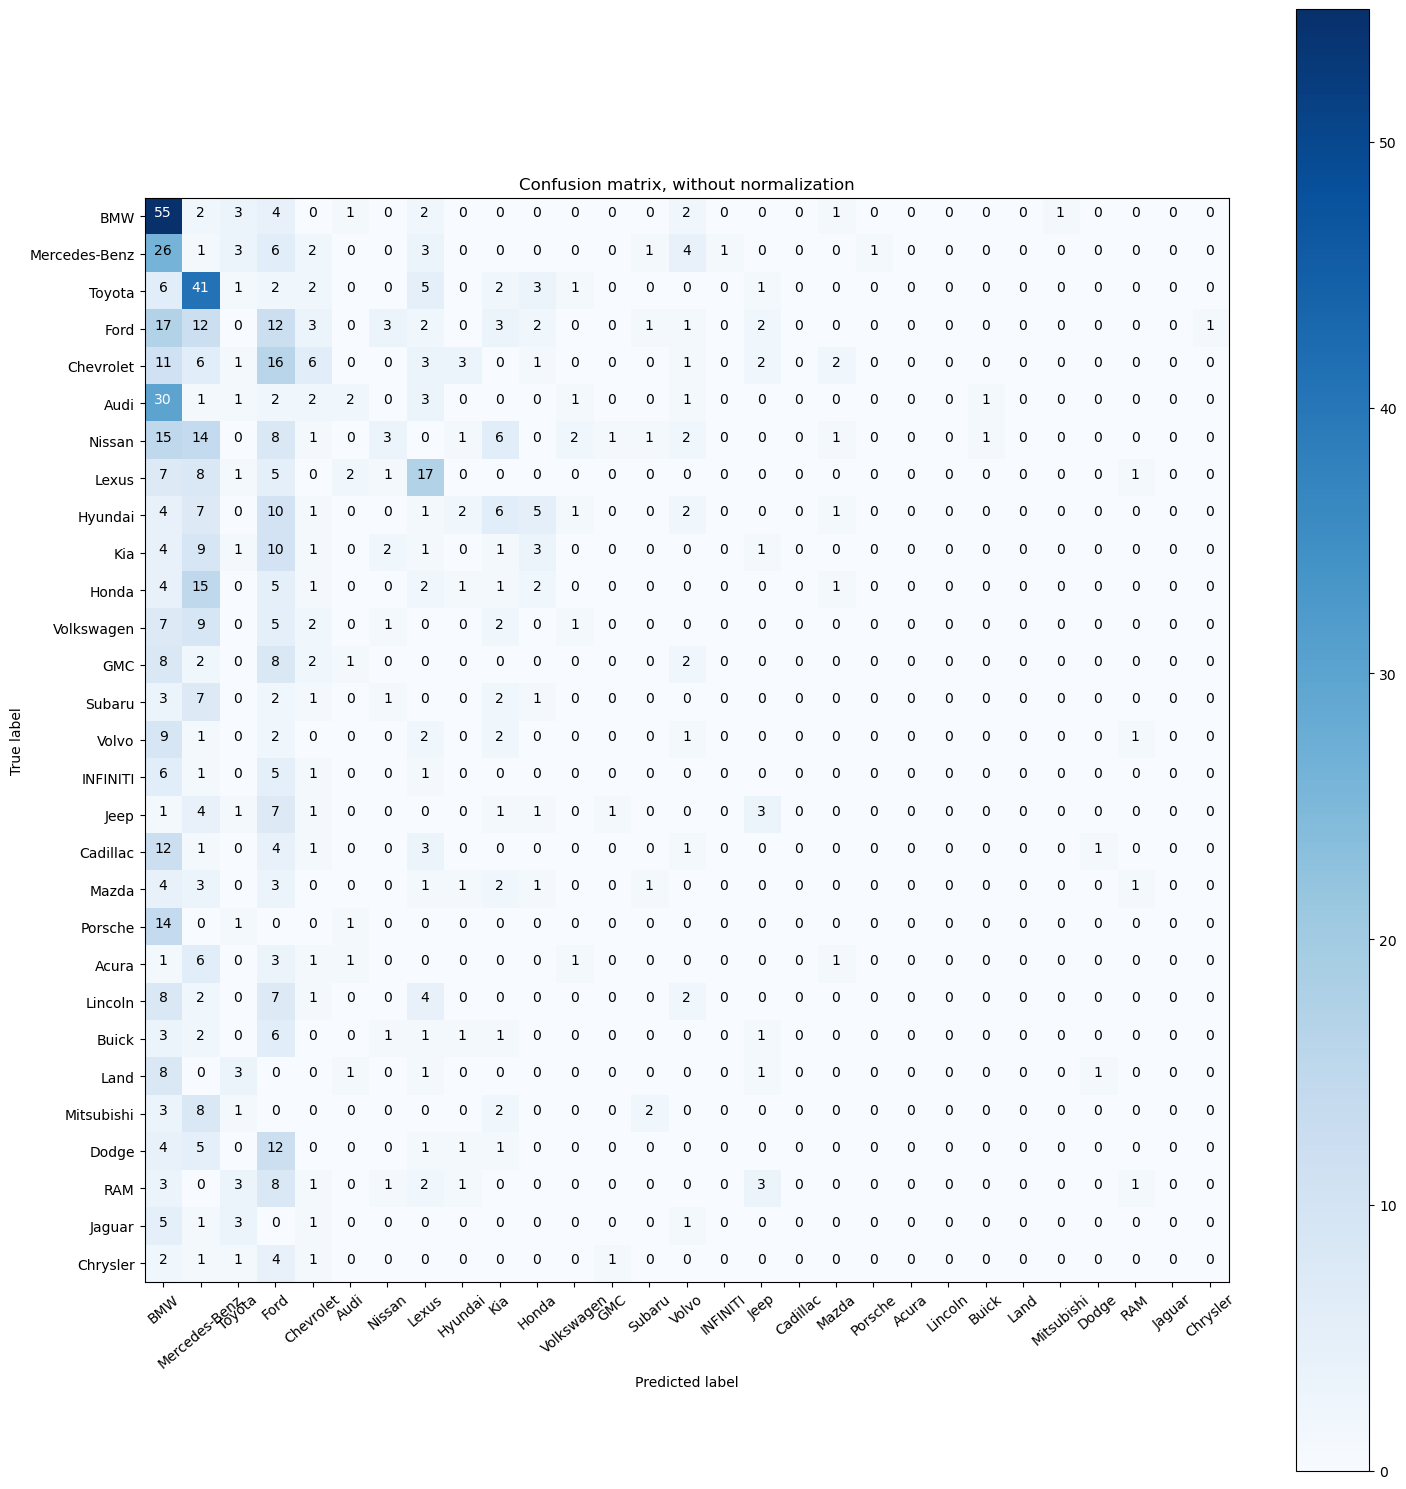

In [41]:
log_reg_test_pred=invert_indexedlabel_to_string(log_reg_test_pred,indexer.labels)
cnf_matrix=confusion_matrics(log_reg_test_pred)
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show();

<a id="binary" ></a>
# Binary Class Classification Without Log Transformation

#### Reducing Multiclass to Binary Class, and fit skewed variables to models without any transformation.

In [1]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder,Normalizer
from pyspark.ml.classification import OneVsRest, LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', None)
from pyspark.sql.functions import isnan, when, count, col, sqrt,avg,log1p
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [3]:
SparkSession.getActiveSession()

In [4]:
spark = SparkSession.builder \
    .master("local")\
    .appName("Car Ratings Classification Project2") \
    .getOrCreate()

In [119]:
car_ratings_sd=spark.read.csv(
    path="car_rates_modified.csv",
    header=True,
    inferSchema=True
)

In [120]:
car_ratings_sd.printSchema()

root
 |-- num_of_reviews: double (nullable = true)
 |-- comfort: double (nullable = true)
 |-- interior_design: double (nullable = true)
 |-- performance: double (nullable = true)
 |-- value_for_the_money: double (nullable = true)
 |-- exterior_styling: double (nullable = true)
 |-- reliability: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- model: string (nullable = true)



In [121]:
luxury_brands=[
    'BMW',
    'Mercedes-Benz',
    'Audi',
    'Lexus',
    'Volvo',
    'Cadillac',
    'Porsche',
    'Acura',
    'Lincoln',
    'Land',
    'Jaguar'
]

In [122]:
car_ratings_sd=car_ratings_sd.withColumn("binary_label",when(col("brand").isin(luxury_brands),"Luxury Brands")\
                         .otherwise("Non luxury Brands"))

In [123]:
car_ratings_sd.select("brand","binary_label").show(5)

+-----+-------------+
|brand| binary_label|
+-----+-------------+
|Acura|Luxury Brands|
|Acura|Luxury Brands|
|Acura|Luxury Brands|
|Acura|Luxury Brands|
|Acura|Luxury Brands|
+-----+-------------+
only showing top 5 rows



In [124]:
brand_value_count=car_ratings_sd.groupBy("binary_label").count().orderBy('count',ascending=False).toPandas()

In [125]:
def bar_plot(df,x="",y="",x_name="",y_name="",title=""):
        
    plt.figure(figsize=(20,8))
    sns.barplot(x=df[x],y=df[y])
    plt.xlabel(x_name.upper())
    plt.ylabel(y_name.upper())
    plt.title(title.upper())
    plt.xticks(rotation=50);

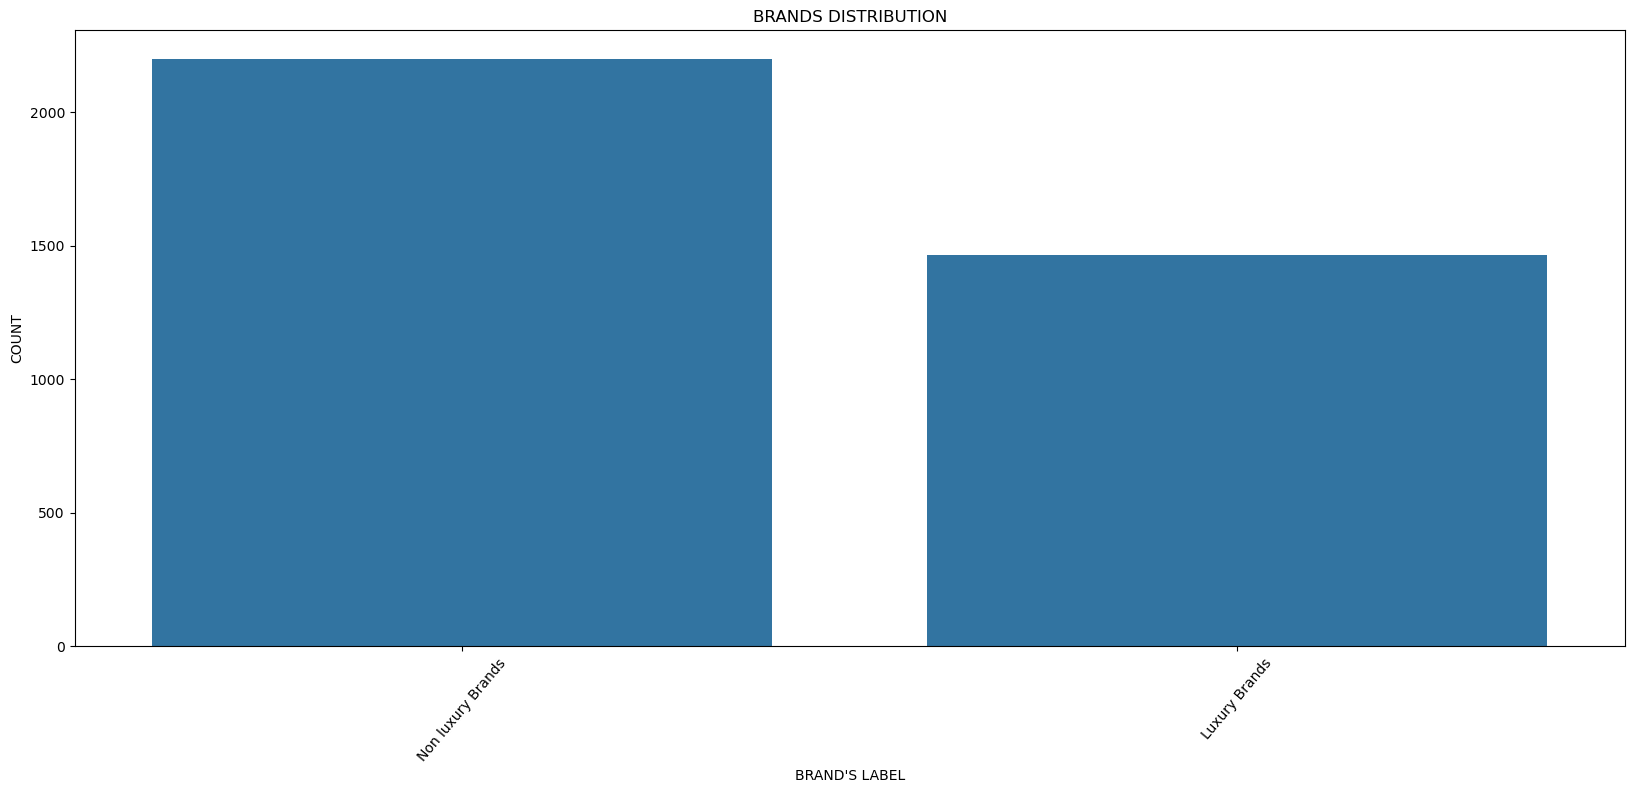

In [126]:
bar_plot(brand_value_count,"binary_label","count","brand's label","count","brands distribution")

In [127]:
car_ratings_sd.groupBy("binary_label").agg(avg("performance")).show()

+-----------------+-----------------+
|     binary_label| avg(performance)|
+-----------------+-----------------+
|Non luxury Brands|4.538671519563252|
|    Luxury Brands|4.730989761092156|
+-----------------+-----------------+



In [128]:
# skewed=["num_of_reviews","comfort","interior_design","performance","value_for_the_money","exterior_styling","reliability"]
# for name in car_ratings_sd.schema.names:
#     if name in skewed:
        
#         car_ratings_sd=car_ratings_sd.withColumn(
#             name,log1p(col(name))
#         )

In [129]:
#data pre-processing
indexer = StringIndexer(inputCol="binary_label", outputCol="brand_label") 
car_ratings_sd=indexer.fit(car_ratings_sd).transform(car_ratings_sd)
car_ratings_sd=car_ratings_sd.withColumn('brand_label', car_ratings_sd.brand_label.cast('int'))
features=['num_of_reviews',
                 'comfort',
                 'interior_design',
                 'performance',
                 'value_for_the_money',
                 'exterior_styling',
                 'reliability',
                 'year',
]
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
car_ratings_sd=vector_assembler.transform(car_ratings_sd)
normalizer = Normalizer(inputCol="features",outputCol="input_features", p=1.0)
car_ratings_sd = normalizer.transform(car_ratings_sd)

In [130]:
train, test = car_ratings_sd.randomSplit([0.75, 0.25],seed = 42)
train.toPandas().to_csv("train_data_with_binaryLabel.csv",index=False)
test.toPandas().to_csv("test_data_with_binaryLabel.csv",index=False)

In [131]:
train.select("brand","binary_label","brand_label").show(5)

+--------+-----------------+-----------+
|   brand|     binary_label|brand_label|
+--------+-----------------+-----------+
|     GMC|Non luxury Brands|          0|
|     GMC|Non luxury Brands|          0|
|     BMW|    Luxury Brands|          1|
|INFINITI|Non luxury Brands|          0|
|  Nissan|Non luxury Brands|          0|
+--------+-----------------+-----------+
only showing top 5 rows



<a id="gbt" ></a>
# 1. Gradient Boosted Tree Classifier

In [132]:
from pyspark.ml.classification import GBTClassifier

In [133]:
gbt = GBTClassifier(featuresCol="input_features",labelCol="brand_label")
gbt_model = gbt.fit(train)

In [134]:
training_predictions=gbt_model.transform(train)

In [135]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(training_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(training_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(training_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.8225823465558393 
Accuracy: 0.8232
Area Under the Curve (AUC): 0.8138012620388373 


In [136]:
training_predictions.select("brand_label","prediction").show(5)

+-----------+----------+
|brand_label|prediction|
+-----------+----------+
|          0|       0.0|
|          0|       0.0|
|          1|       0.0|
|          0|       0.0|
|          0|       0.0|
+-----------+----------+
only showing top 5 rows



In [137]:
training_predictions = training_predictions.withColumn("prediction", col("prediction").cast("int"))


In [138]:
training_predictions.select("brand_label","prediction").show(5)

+-----------+----------+
|brand_label|prediction|
+-----------+----------+
|          0|         0|
|          0|         0|
|          1|         0|
|          0|         0|
|          0|         0|
+-----------+----------+
only showing top 5 rows



In [139]:
training_predictions=training_predictions.withColumn("brand_label",when(training_predictions.brand_label == 0,"Non Luxury Brands")\
                                                    .when(training_predictions.brand_label == 1,"Luxury Brands"))

In [140]:
training_predictions=training_predictions.withColumn("prediction",when(training_predictions.prediction == 0,"Non Luxury Brands")\
                                                    .when(training_predictions.prediction == 1,"Luxury Brands"))

In [141]:
training_predictions.select("brand_label","prediction").show(5)

+-----------------+-----------------+
|      brand_label|       prediction|
+-----------------+-----------------+
|Non Luxury Brands|Non Luxury Brands|
|Non Luxury Brands|Non Luxury Brands|
|    Luxury Brands|Non Luxury Brands|
|Non Luxury Brands|Non Luxury Brands|
|Non Luxury Brands|Non Luxury Brands|
+-----------------+-----------------+
only showing top 5 rows



In [142]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

In [143]:
from sklearn.metrics import confusion_matrix
def confusion_matrixF(df,label_col="",prediction_col=""):
    class_temp = df.select(label_col).groupBy(label_col).count().sort('count', ascending=False).toPandas()
    class_names = class_temp[label_col].values.tolist()
    y_true = df.select(label_col)
    y_true = y_true.toPandas()
    y_pred = df.select(prediction_col)
    y_pred = y_pred.toPandas()
    cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
    return cnf_matrix,class_names

Confusion matrix, without normalization


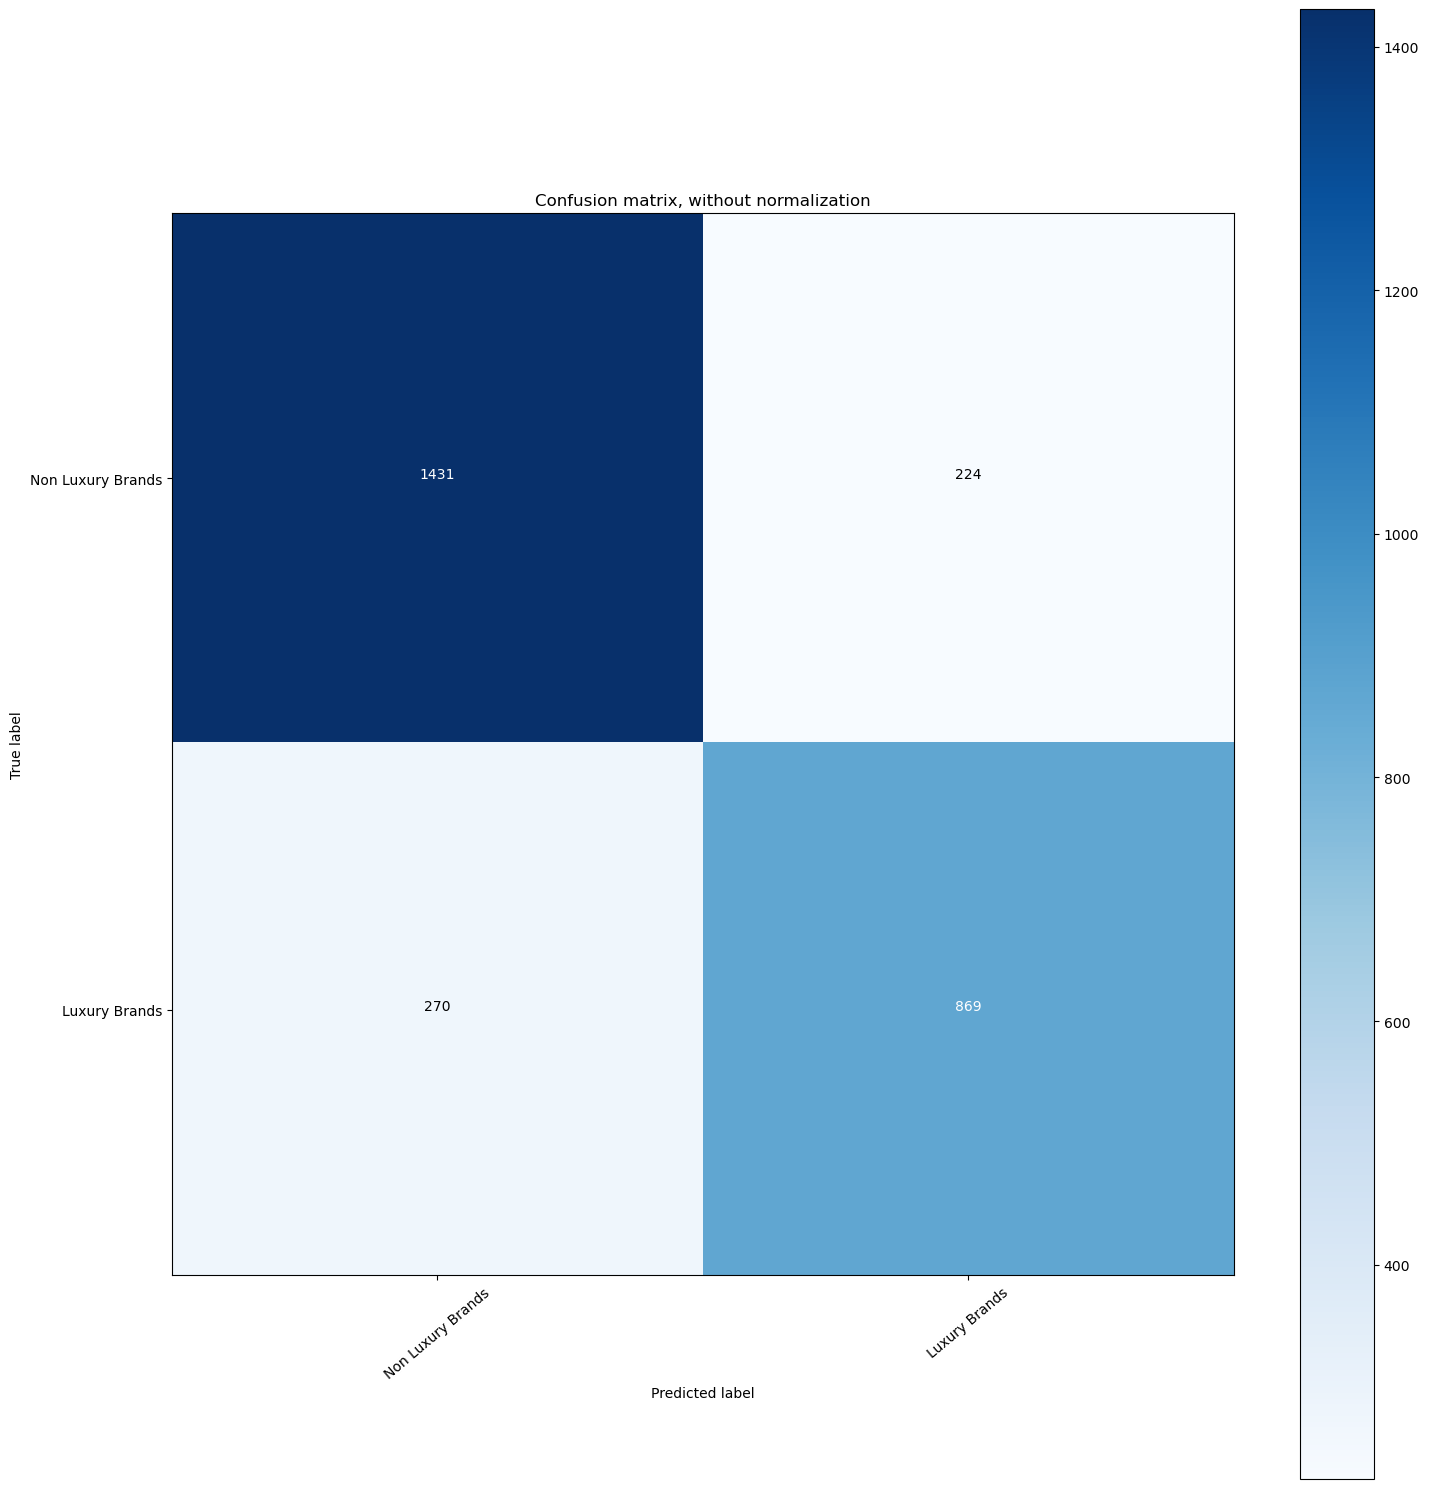

In [144]:
cnf_matrix,class_names=confusion_matrixF(training_predictions,"brand_label","prediction")
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show();

In [145]:
model_predictions = gbt_model.transform(test)

In [146]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(model_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(model_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(model_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7478025762574297 
Accuracy: 0.7491
Area Under the Curve (AUC): 0.7275503056186376 


In [147]:
model_predictions.select("brand_label","prediction").show(5)

+-----------+----------+
|brand_label|prediction|
+-----------+----------+
|          0|       0.0|
|          0|       0.0|
|          1|       0.0|
|          1|       0.0|
|          0|       0.0|
+-----------+----------+
only showing top 5 rows



In [148]:
model_predictions=model_predictions.withColumn("brand_label",when(model_predictions.brand_label == 0,"Non Luxury Brands")\
                                                    .when(model_predictions.brand_label == 1,"Luxury Brands"))
model_predictions=model_predictions.withColumn("prediction",when(model_predictions.prediction == 0.0,"Non Luxury Brands")\
                                                    .when(model_predictions.prediction == 1.0,"Luxury Brands"))

In [149]:
training_predictions.select("brand_label","prediction").show(5)

+-----------------+-----------------+
|      brand_label|       prediction|
+-----------------+-----------------+
|Non Luxury Brands|Non Luxury Brands|
|Non Luxury Brands|Non Luxury Brands|
|    Luxury Brands|Non Luxury Brands|
|Non Luxury Brands|Non Luxury Brands|
|Non Luxury Brands|Non Luxury Brands|
+-----------------+-----------------+
only showing top 5 rows



Confusion matrix, without normalization


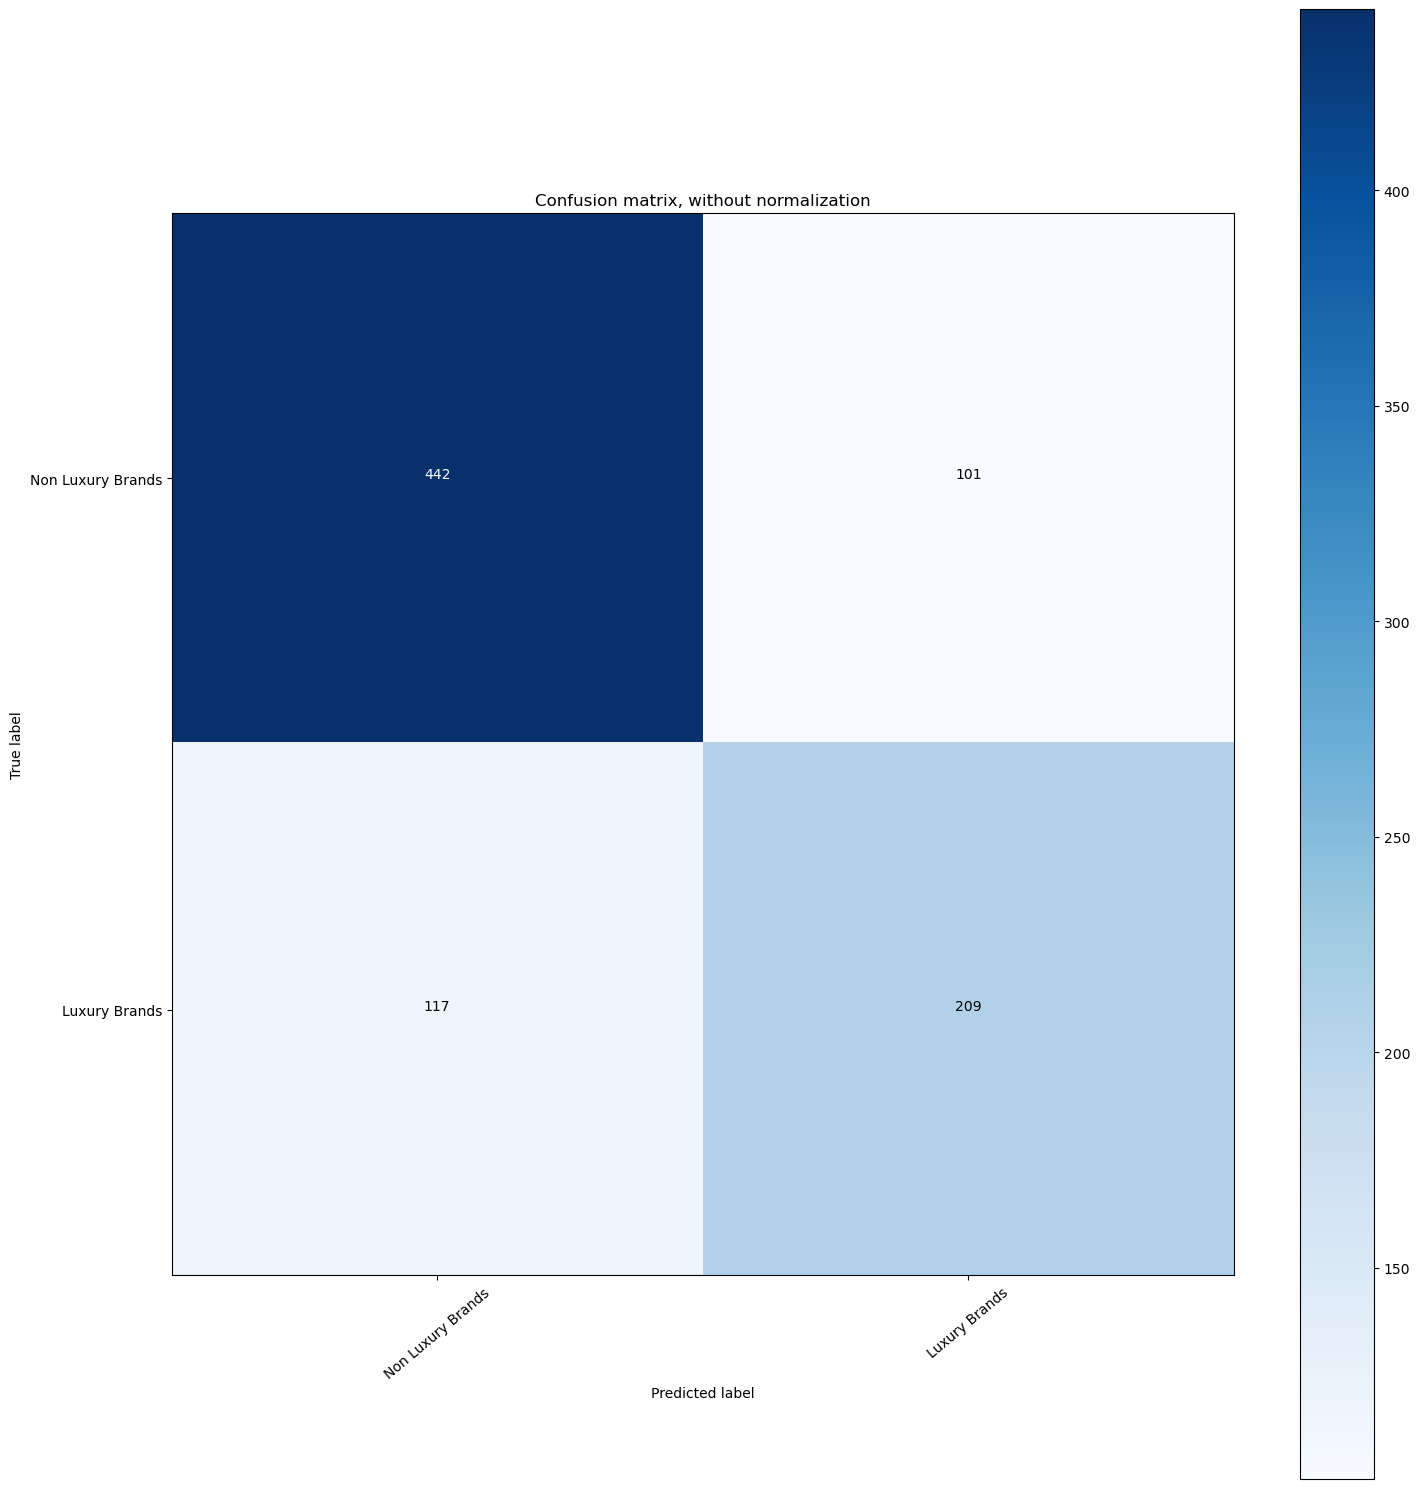

In [150]:

cnf_matrix,class_names=confusion_matrixF(model_predictions,"brand_label","prediction")
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show();

In [151]:
# Filter misclassified data in luxury brands to explore it more.
misclassfied_luxury=model_predictions.filter(model_predictions.brand_label=="Luxury Brands").filter(model_predictions.prediction=="Non Luxury Brands")

In [152]:
misclassfied_luxury.columns

['num_of_reviews',
 'comfort',
 'interior_design',
 'performance',
 'value_for_the_money',
 'exterior_styling',
 'reliability',
 'year',
 'brand',
 'model',
 'binary_label',
 'brand_label',
 'features',
 'input_features',
 'rawPrediction',
 'probability',
 'prediction']

In [153]:
cols=['num_of_reviews',
 'comfort',
 'interior_design',
 'performance',
 'value_for_the_money',
 'exterior_styling',
 'reliability',
 'year',
 'brand',
 'brand_label',
 'prediction']

In [154]:
misclassfied_luxury=misclassfied_luxury.select(cols)

In [155]:
misclassfied_luxury.show()

+--------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-------------+-------------+-----------------+
|num_of_reviews|comfort|interior_design|performance|value_for_the_money|exterior_styling|reliability|year|        brand|  brand_label|       prediction|
+--------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-------------+-------------+-----------------+
|           1.0|    3.0|            3.0|        3.0|                1.0|             3.0|        3.0|2023|        Lexus|Luxury Brands|Non Luxury Brands|
|           1.0|    3.0|            3.0|        4.0|                4.0|             4.0|        4.0|2022|Mercedes-Benz|Luxury Brands|Non Luxury Brands|
|           1.0|    5.0|            4.0|        3.0|                3.0|             5.0|        4.0|2022|     Cadillac|Luxury Brands|Non Luxury Brands|
|           1.0|    5.0|            4.0|        5.0|                5.0|          

In [163]:
print(f"""Most frequent brands in misclassified class: "Luxury Class"\n {misclassfied_luxury.groupBy("brand").count().orderBy('count',ascending=False).show()}""")

+-------------+-----+
|        brand|count|
+-------------+-----+
|        Lexus|   27|
|      Lincoln|   18|
|          BMW|   18|
|Mercedes-Benz|   13|
|         Audi|   10|
|        Acura|   10|
|     Cadillac|    9|
|        Volvo|    7|
|         Land|    2|
|      Porsche|    2|
|       Jaguar|    1|
+-------------+-----+

Most frequent brands in misclassified class: "Luxury Class"
 None


In [169]:
misclassfied_luxury=misclassfied_luxury.toPandas()

In [171]:
pd.set_option('display.max_rows', None)
misclassfied_luxury

,num_of_reviews,comfort,interior_design,performance,value_for_the_money,exterior_styling,reliability,year,brand,brand_label,prediction
0,1.0,3.0,3.0,3.0,1.0,3.0,3.0,2023,Lexus,Luxury Brands,Non Luxury Brands
1,1.0,3.0,3.0,4.0,4.0,4.0,4.0,2022,Mercedes-Benz,Luxury Brands,Non Luxury Brands
2,1.0,5.0,4.0,3.0,3.0,5.0,4.0,2022,Cadillac,Luxury Brands,Non Luxury Brands
3,1.0,5.0,4.0,5.0,5.0,5.0,5.0,2021,Volvo,Luxury Brands,Non Luxury Brands
4,1.0,5.0,5.0,4.0,4.0,5.0,4.0,2022,Mercedes-Benz,Luxury Brands,Non Luxury Brands
5,2.0,4.5,4.5,4.0,4.0,4.0,4.0,2022,Audi,Luxury Brands,Non Luxury Brands
6,2.0,4.5,4.5,5.0,5.0,4.5,5.0,2012,BMW,Luxury Brands,Non Luxury Brands
7,3.0,3.7,3.7,3.7,3.3,3.7,3.0,2018,BMW,Luxury Brands,Non Luxury Brands
8,3.0,4.3,4.3,4.7,5.0,5.0,5.0,2022,Acura,Luxury Brands,Non Luxury Brands
9,3.0,5.0,5.0,5.0,5.0,5.0,5.0,2017,BMW,Luxury Brands,Non Luxury Brands


# 2. Decision Ttree Cclassifiers.

In [172]:
Dt = DecisionTreeClassifier(featuresCol="input_features",labelCol="brand_label")
Dt_model = Dt.fit(train)

In [173]:
training_predictions=Dt_model.transform(train)

In [174]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(training_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(training_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(training_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7436928968339249 
Accuracy: 0.7509
Area Under the Curve (AUC): 0.723895185526075 


In [175]:
model_predictions = Dt_model.transform(test)

In [176]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(model_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(model_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(model_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.6876689733803287 
Accuracy: 0.6997
Area Under the Curve (AUC): 0.6530183371182591 


<a id="lrT" ></a>
# 3. Logistic Regression.

In [183]:
log_reg=LogisticRegression(featuresCol="input_features",labelCol="brand_label")

In [184]:
log_reg_training=log_reg.fit(train)

In [185]:
log_reg_training_pred=log_reg_training.transform(train)

In [186]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(log_reg_training_pred)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(log_reg_training_pred)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(log_reg_training_pred)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7523096575325456 
Accuracy: 0.7530
Area Under the Curve (AUC): 0.7415844184091096 


In [187]:
log_reg_test_pred=log_reg_training.transform(test)

In [188]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(log_reg_test_pred)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(log_reg_test_pred)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(log_reg_test_pred)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7522516804692766 
Accuracy: 0.7537
Area Under the Curve (AUC): 0.7318464788891524 


In [200]:
log_reg_test_pred=log_reg_test_pred.withColumn("brand_label",when(log_reg_test_pred.brand_label == 0,"Non Luxury Brands")\
                                                    .when(log_reg_test_pred.brand_label == 1,"Luxury Brands"))
log_reg_test_pred=log_reg_test_pred.withColumn("prediction",when(log_reg_test_pred.prediction == 0.0,"Non Luxury Brands")\
                                                    .when(log_reg_test_pred.prediction == 1.0,"Luxury Brands"))

Confusion matrix, without normalization


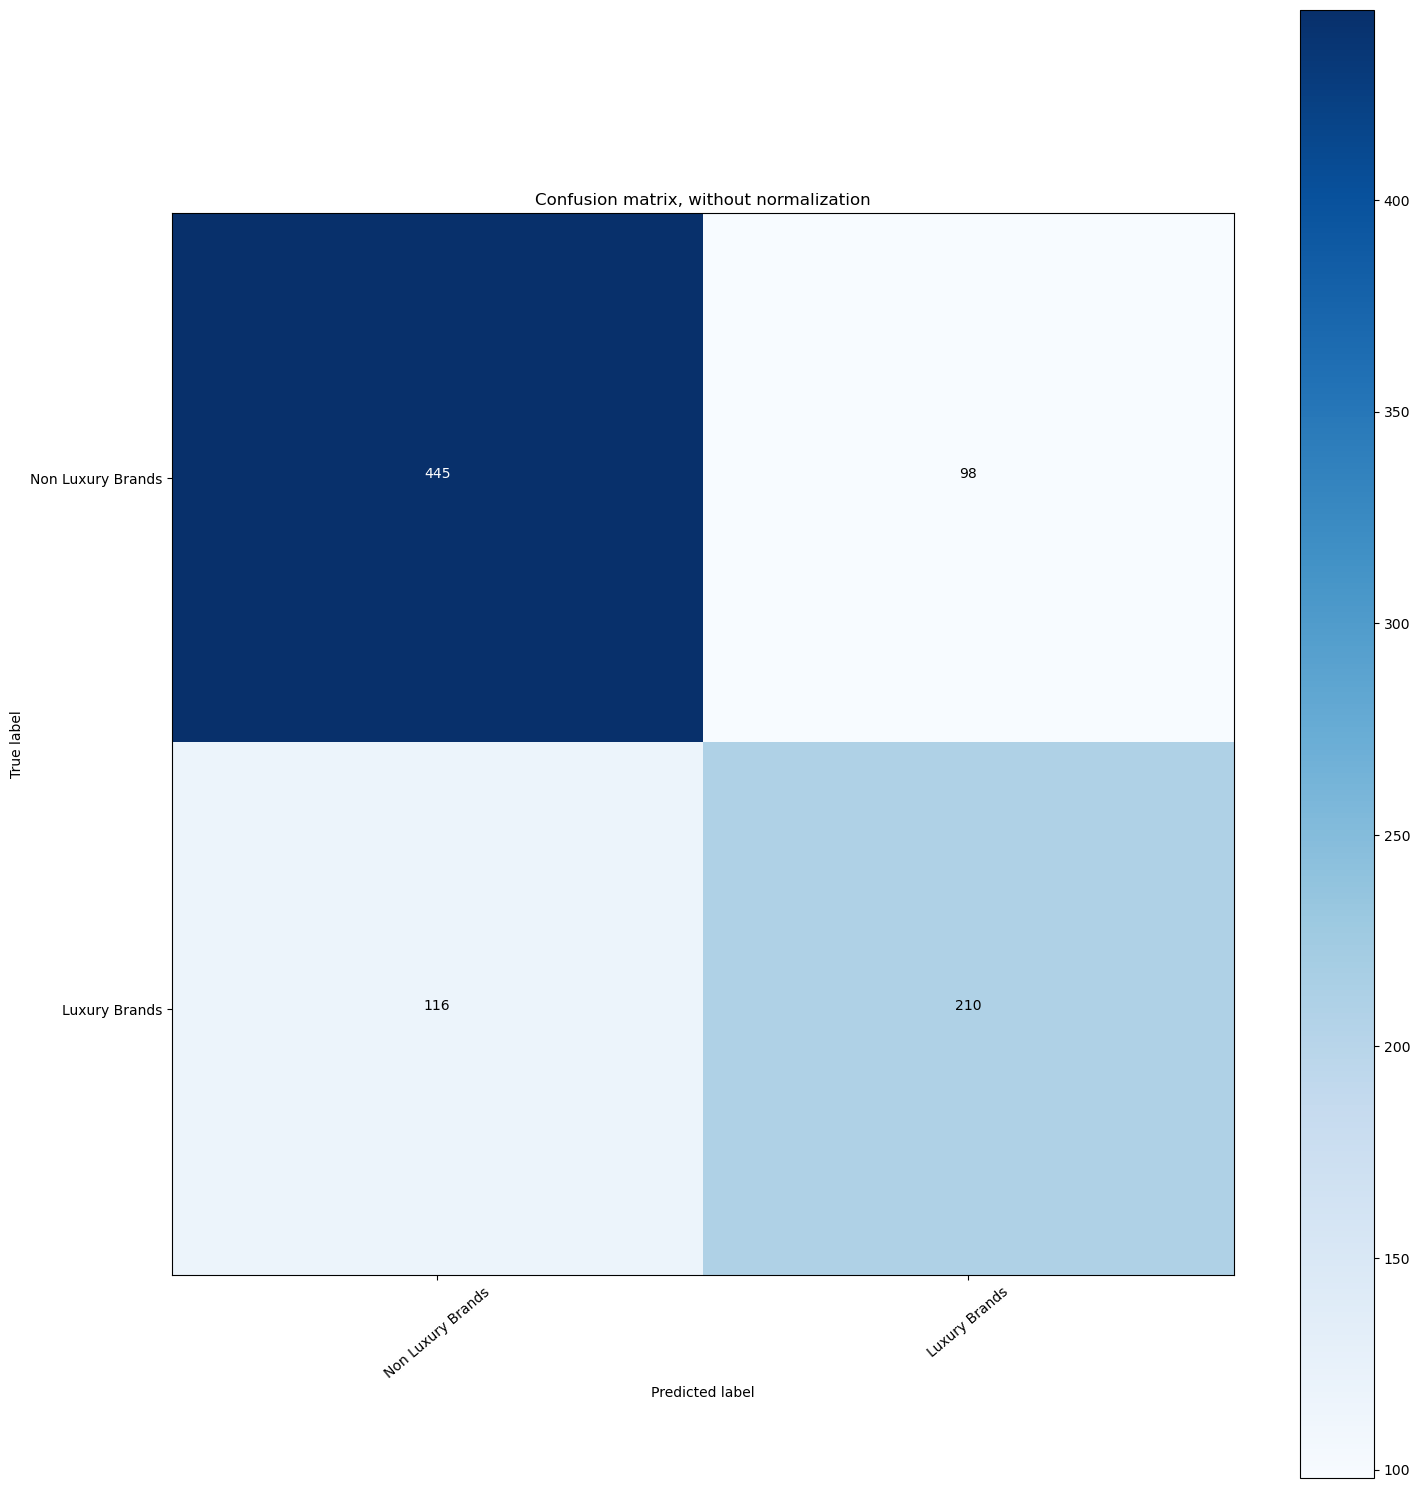

In [201]:
cnf_matrix,class_names=confusion_matrixF(log_reg_test_pred,"brand_label","prediction")
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show();

# 4.Random Forest.

In [189]:
rf=RandomForestClassifier(featuresCol="input_features",labelCol="brand_label",numTrees=50)

In [190]:
rf_model=rf.fit(train)

In [191]:
training_predictions=rf_model.transform(train)

In [192]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(training_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(training_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(training_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7646633869449071 
Accuracy: 0.7656
Area Under the Curve (AUC): 0.7538008376457856 


In [193]:
model_predictions = rf_model.transform(test)

In [194]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(model_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(model_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(model_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7415470651399254 
Accuracy: 0.7434
Area Under the Curve (AUC): 0.719881593962196 


<a id="binary2" ></a>
# Binary Class Classification With Log Transformation

#### Train gradient-boosted tree classifier and Logistic regression with Logarithmic Transformation.

In [221]:
train=spark.read.csv(
    path="train_data_with_binaryLabel.csv",
    header=True,
    inferSchema=True
)
test=spark.read.csv(
    path="test_data_with_binaryLabel.csv",
    header=True,
    inferSchema=True
)


In [222]:
train.limit(2).toPandas()

,num_of_reviews,comfort,interior_design,performance,value_for_the_money,exterior_styling,reliability,year,brand,model,binary_label,brand_label,features,input_features
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2017,GMC,Savana 3500.,Non luxury Brands,0,"[1.0,1.0,1.0,1.0,1.0,1.0,1.0,2017.0]","[0.0004940711462450593,0.0004940711462450593,0.0004940711462450593,0.0004940..."
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2020,GMC,Savana 2500.,Non luxury Brands,0,"[1.0,1.0,1.0,1.0,1.0,1.0,1.0,2020.0]","[0.000493339911198816,0.000493339911198816,0.000493339911198816,0.0004933399..."


In [223]:
skewed=skewed=["comfort","interior_design","performance","value_for_the_money","exterior_styling","reliability","num_of_reviews"]
for name in train.schema.names:
    if name in skewed:
        
        train=train.withColumn(
            name,log1p(col(name))
        )
for name in test.schema.names:
    if name in skewed:
        
        test=test.withColumn(
            name,log1p(col(name))
        )

In [225]:
features=["comfort","interior_design","performance","value_for_the_money","exterior_styling","reliability","num_of_reviews",
                 'year'
]
vector_assembler = VectorAssembler(inputCols=features, outputCol="features2")
train=vector_assembler.transform(train)
normalizer = Normalizer(inputCol="features2",outputCol="input_features2", p=1.0)
train = normalizer.transform(train)
# same to test data
vector_assembler = VectorAssembler(inputCols=features, outputCol="features2")
test=vector_assembler.transform(test)
normalizer = Normalizer(inputCol="features2",outputCol="input_features2", p=1.0)
test = normalizer.transform(test)

In [226]:
train.columns

['num_of_reviews',
 'comfort',
 'interior_design',
 'performance',
 'value_for_the_money',
 'exterior_styling',
 'reliability',
 'year',
 'brand',
 'model',
 'binary_label',
 'brand_label',
 'features',
 'input_features',
 'features2',
 'input_features2']

<a id="binarya" ></a>
### Logistic Regression

In [227]:
log_reg=LogisticRegression(featuresCol="input_features2",labelCol="brand_label")

In [228]:
log_reg_training=log_reg.fit(train)

In [229]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(log_reg_training_pred)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(log_reg_training_pred)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(log_reg_training_pred)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7523096575325456 
Accuracy: 0.7530
Area Under the Curve (AUC): 0.7415844184091096 


In [230]:
log_reg_test_pred=log_reg_training.transform(test)

In [231]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(log_reg_test_pred)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(log_reg_test_pred)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(log_reg_test_pred)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7397896670258142 
Accuracy: 0.7445
Area Under the Curve (AUC): 0.7128342880385045 


<a id="binaryb" ></a>
# Gradient boosted tree classifier

In [232]:
gbt = GBTClassifier(featuresCol="input_features2",labelCol="brand_label")
gbt_model = gbt.fit(train)

In [233]:
training_predictions=gbt_model.transform(train)

In [234]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(training_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(training_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(training_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.8289103862341929 
Accuracy: 0.8304
Area Under the Curve (AUC): 0.8173799564466631 


In [235]:
model_predictions = gbt_model.transform(test)

In [236]:
auroc = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="brand_label",metricName='areaUnderROC')
auroc=auroc.evaluate(model_predictions)
f1_score = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label")
f1_score = f1_score.evaluate(model_predictions)
accuracy= MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="brand_label",metricName="accuracy")
accuracy=accuracy.evaluate(model_predictions)
print(f"F1 Score:{f1_score} \nAccuracy: {accuracy:.4f}\nArea Under the Curve (AUC): {auroc} ")

F1 Score:0.7529510586754943 
Accuracy: 0.7549
Area Under the Curve (AUC): 0.7315414251658023 
